<a href="https://colab.research.google.com/github/shntnu/whitening/blob/master/deconstruct_sphering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deconstruct sphering

Our current approach for sphering in [`pycytominer`](https://github.com/cytomining/pycytominer/blob/388bc35cdc044da8f2bdcbd8edbfa2bf66cf1198/pycytominer/operations/transform.py#L42-L108) and [`cytominer`](https://github.com/cytomining/cytominer/blob/3fe522a81b5fd239c12ceb2c66e93951dbb71ca4/R/spherize.R) is suboptimal for cases where we have more observations than variables. There are four issues, in increasing order of importance

1. For our data, it only makes sense to perform sphering on data where the features are on a common scale, e.g. by normalization. We currently don't impose this; this is a matter of documentation only.

1. We compute the eigen-decomposition of the regularized covariance matrix. This is unnecessary; we can use SVD instead. This is mostly a time and space complexity issue. It might also be a numerical stability issue, although stability matters only for small eigenvalues and can be mitigated by adding a regularizer, so that's probably not a big deal.

1. We haven't given much thought to the $\epsilon$ parameter (default is `1e-6` in `pycytominer`). The parameter does not matter much when you have many, many more observations $n$ than variables $d$, but that's often not the case for us. When $n \lt d$, setting $\epsilon$ too low can result in (effectively) trimming too many dimensions. Interestingly, when $n \ll d$ and we don't have enough $n$ to capture the number of principal components of systematic noise, setting the parameter to a very small value (like $1e-6$) is fine because we do want to drop whatever few PCs's we can estimate.

1. Perhaps most importantly, we should just drop the PCs in which we see significant variance, instead of only scaling it down. This is effectively just an orthogonal projection of the data into the subspace where there's no systematic noise, and this is likely the best way of sphering the data, provided we can get a good estimate of the number of true dimensions of systematic variance. 
  
  **Late-breaking counterpoint:** it's possible that by dropping the top PCs is bad because sphering is all about decorrelating the data. TBD

Here's the modified approach. I get the sense that there's a further simplification of all this but penning it down will help towards that.

1. Given a mean-centered, unit variance matrix $X_{negcon} \in \mathbb{R}^{n \times d}$, decompose it into $USV^T$, where $V$ is always the "full" $V$ i.e. $V \in \mathbb{R}^{n \times d}$, even if $n \le d$. 

1. Next, pick your favorite approach for finding $k$, the number of significant PC's (e.g. parallel analysis if you want to do it automatically). Note that $S$ has the *square root* of the eigenvalues of the covariance matrix when doing this analysis.

3. Define $\tilde{S} \leftarrow S + \epsilon$. Regularize by a small amount ($\epsilon = 1e-6$) to avoid stability issues with estimating small eigenvalues.

4. If $r \lt d$: $\tilde{S}_{r+1:n,r+1:n} \leftarrow S_{r,r}$ and $\tilde{S}_{n+1:d, n+1:d} \leftarrow \sqrt{n/d}S_{r,r}$     
  
  - The $\sqrt{n/d}$ factor is a heuristic that I'm not yet able to explain nicely. 
  - We seem to need treat $\tilde{S}_{r+1:n,r+1:n}$ differently from $\tilde{S}_{n+1:d,n+1:d}$ to stabilize the variance of the $PC_{r+1:n}$; I'm not yet sure why we need to do this but it fixes the issue of a spike in variance.

4. Define 
  - $V_k \doteq V_{:,k+1:d}$
  - $\tilde{S}_k \doteq \tilde{S}_{k+1:d,k+1:d}$

5. Correct $X$ (treatments + negative controls, centered and scaled to the mean and s.d. of negative controls) in one of the following ways

  1. $X_w \doteq XV\tilde{S}^{-1}$ producing $X_w \in \mathbb{R}^{n \times d}$. 
  2. $X_w \doteq XV_k\tilde{S}_k^{-1}$ producing $X_w \in \mathbb{R}^{n \times (d-k)}$.
  3. $X_w \doteq XV_k$ producing $X_w \in \mathbb{R}^{n \times (d-k)}$.



Our current approach is equivalent to doing 4.1 except that $\tilde{S}$ is created by setting $S_{r+1:d, r+1:d}$ to an arbitrarily small $\epsilon$. We typically choose $\epsilon = 10^{-6}$.  A very small value of $\epsilon$ is equivalent to orthogonally projecting the data into the null space of $X_{negcon}$ i.e $X_w \doteq XV_r$. This is especially problematic if $k \ll r < d$, resulting in our dropping too many PCs that are *not* affected by systematic noise.

If we can explain the hacks needed to create $\tilde{S}$, I think 5.1 is likely the best way of sphering the data when $n \ll d$. 

When $n \gg d$, no hacks are needed in 5.1, and it is the best way of sphering the data (and is conceptually the same as our current method for sphering).



Other notes
1. Given stability issues with estimating small eigenvalues, using the smallest one to extend out into the null space seems bad. But as long as we have an $\epsilon$, I think we are fine.
1. When $n \lt d$, the maximum rank of $X_{negcon}$ is $n-1$, and not $n$, because of mean centering. This is important to keep in mind because the smallest singular value you will observe with SVD on $X_{negcon}$ will be super tiny, but that's because you're looking at $S_{n,n}$ whereas you should be looking at $S_{n-1,n-1}$ or lower (the rank can be less than $n-1$ if you have highly correlated features)
1. Our current approach of (effectively) adding $\epsilon$ to the covariance matrix has a very significant side effect: it essentially offers you the entire null space $X_{negcon}$ in which to project your data. The null space of $X_{negcon}$ is exactly the space we need (in additional to the subspace of the row space where $X_{negcon}$. But we can just get to it directly with SVD! 


References
- https://ocw.mit.edu/courses/mathematics/18-996-random-matrix-theory-and-its-applications-spring-2004/lecture-notes/thesis.pdf
- https://en.wikipedia.org/wiki/Wigner_semicircle_distribution
- https://en.wikipedia.org/wiki/Wigner_surmise
- http://www.stats.ox.ac.uk/~cucuring/Lecture_4_PCA_RMTX_Finance.pdf (slide 5, 35 are particularly interesting)
- https://link.springer.com/article/10.1007/s11336-016-9515-z
https://cran.r-project.org/web/packages/jackstraw/vignettes/jackstraw.pdf

In [1]:
import pandas as pd
import numpy as np
import scipy
from scipy import linalg
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import math
from sklearn.decomposition import PCA
from scipy.stats import special_ortho_group
from scipy.linalg import eigh
from scipy.linalg import eig


## Load Cell Health data

In [2]:
url = "https://raw.githubusercontent.com/broadinstitute/grit-benchmark/main/1.calculate-metrics/cell-health/data/cell_health_merged_feature_select.csv.gz"
profiles = pd.read_csv(url)

Trim it down to just the wells with no CRISPR treatment. These are the references wells using which we will spherize our data.

In [3]:
empty = profiles.query("Metadata_gene_name == 'EMPTY' & Metadata_cell_line == 'HCC44' & Metadata_Plate == 'SQ00014618'")
print(empty.shape)
empty.head()

(56, 402)


,Metadata_Plate,Metadata_Well,Metadata_WellCol,Metadata_WellRow,Metadata_cell_line,Metadata_gene_name,Metadata_pert_name,Cells_AreaShape_Compactness,Cells_AreaShape_Extent,Cells_AreaShape_Zernike_0_0,Cells_AreaShape_Zernike_1_1,Cells_AreaShape_Zernike_2_0,Cells_AreaShape_Zernike_2_2,Cells_AreaShape_Zernike_3_3,Cells_AreaShape_Zernike_4_0,Cells_AreaShape_Zernike_4_2,Cells_AreaShape_Zernike_5_1,Cells_AreaShape_Zernike_5_3,Cells_AreaShape_Zernike_6_0,Cells_AreaShape_Zernike_6_2,Cells_AreaShape_Zernike_6_4,Cells_AreaShape_Zernike_7_1,Cells_AreaShape_Zernike_7_3,Cells_AreaShape_Zernike_8_0,Cells_AreaShape_Zernike_8_2,Cells_AreaShape_Zernike_8_4,Cells_AreaShape_Zernike_8_6,Cells_AreaShape_Zernike_9_1,Cells_AreaShape_Zernike_9_3,Cells_AreaShape_Zernike_9_5,Cells_Correlation_Correlation_DNA_ER,Cells_Correlation_Correlation_DNA_Mito,Cells_Correlation_Correlation_ER_RNA,Cells_Correlation_Correlation_Mito_AGP,Cells_Correlation_Correlation_Mito_RNA,Cells_Correlation_K_AGP_DNA,Cells_Correlation_K_AGP_ER,Cells_Correlation_K_Mito_DNA,Cells_Correlation_K_RNA_DNA,Cells_Correlation_Overlap_DNA_AGP,...,Nuclei_Texture_Entropy_RNA_5_0,Nuclei_Texture_Gabor_AGP_10,Nuclei_Texture_Gabor_AGP_20,Nuclei_Texture_Gabor_DNA_10,Nuclei_Texture_Gabor_DNA_20,Nuclei_Texture_Gabor_DNA_5,Nuclei_Texture_Gabor_ER_20,Nuclei_Texture_Gabor_ER_5,Nuclei_Texture_Gabor_Mito_10,Nuclei_Texture_Gabor_Mito_20,Nuclei_Texture_Gabor_Mito_5,Nuclei_Texture_Gabor_RNA_10,Nuclei_Texture_Gabor_RNA_20,Nuclei_Texture_Gabor_RNA_5,Nuclei_Texture_InfoMeas1_AGP_10_0,Nuclei_Texture_InfoMeas1_AGP_20_0,Nuclei_Texture_InfoMeas1_DNA_10_0,Nuclei_Texture_InfoMeas1_DNA_20_0,Nuclei_Texture_InfoMeas1_ER_5_0,Nuclei_Texture_InfoMeas1_Mito_10_0,Nuclei_Texture_InfoMeas1_RNA_20_0,Nuclei_Texture_InfoMeas2_AGP_20_0,Nuclei_Texture_InfoMeas2_DNA_20_0,Nuclei_Texture_InfoMeas2_RNA_20_0,Nuclei_Texture_InverseDifferenceMoment_AGP_10_0,Nuclei_Texture_InverseDifferenceMoment_AGP_5_0,Nuclei_Texture_InverseDifferenceMoment_DNA_10_0,Nuclei_Texture_InverseDifferenceMoment_DNA_20_0,Nuclei_Texture_InverseDifferenceMoment_ER_10_0,Nuclei_Texture_InverseDifferenceMoment_ER_5_0,Nuclei_Texture_InverseDifferenceMoment_Mito_5_0,Nuclei_Texture_InverseDifferenceMoment_RNA_10_0,Nuclei_Texture_InverseDifferenceMoment_RNA_20_0,Nuclei_Texture_SumAverage_AGP_5_0,Nuclei_Texture_SumAverage_ER_5_0,Nuclei_Texture_SumAverage_Mito_20_0,Nuclei_Texture_SumAverage_RNA_5_0,Nuclei_Texture_SumEntropy_ER_5_0,Nuclei_Texture_SumEntropy_Mito_5_0,Nuclei_Texture_SumEntropy_RNA_5_0
0,SQ00014618,A01,1,A,HCC44,EMPTY,EMPTY,-1.515696,0.810956,1.984031,-1.224924,1.903183,-1.738049,-0.910345,-0.472388,-1.429397,-0.721491,-1.906573,-1.356126,1.105012,-0.854987,0.365051,-2.199858,-0.417962,0.007061,-0.279557,-0.050751,-1.479022,-0.468332,-0.951840,-1.946527,-3.547141,-0.978752,-4.280211,-2.379699,-0.179842,-0.254419,1.406585,0.506790,4.025991,...,0.280113,-0.276757,0.081941,1.032481,0.809110,0.740268,0.350041,0.510343,0.705963,1.650693,0.386796,0.448516,0.435387,-0.119492,1.015567,1.004594,0.940352,0.450842,0.379189,2.299479,-0.136309,-1.036626,-0.562014,0.289309,-1.424480,-0.972617,0.461352,0.659751,0.896173,0.184238,-1.365392,-0.351107,-0.163153,2.307568,-2.775524,-3.951667,-1.716353,-2.703082,-3.720976,0.107581
5,SQ00014618,A06,6,A,HCC44,EMPTY,EMPTY,-0.335701,0.218982,0.834575,0.812707,1.043583,-1.504312,-1.422773,0.012318,-0.641587,0.164806,-1.590596,-0.294651,-0.680632,-0.075944,0.142873,0.686176,0.321324,1.808848,1.905454,-0.386406,0.323847,-0.271532,0.589606,-1.671367,-1.993048,-3.113990,-2.189490,-2.649514,0.207595,0.314658,1.238536,-0.075564,2.144528,...,0.360361,1.625307,1.440556,0.697496,0.708615,0.700429,1.363940,0.514825,1.621389,1.578013,2.469579,0.839055,1.058121,0.397315,1.724700,1.581761,1.043190,0.491133,1.831105,3.157728,1.164765,-1.556402,-0.561654,-1.193673,-1.013204,-1.524698,1.355792,2.263444,-1.595891,-1.732801,-3.352000,-1.149020,0.105613,0.838187,-0.449187,-1.159333,-1.452900,-0.277266,-2.344850,-0.925731
7,SQ00014618,A08,8,A,HCC44,EMPT

Get the data matrix and note that $n < d$ here. 

In [4]:
Xe = empty.filter(regex="^(?!Metadata)", axis=1).to_numpy()
colnames = empty.filter(regex="^(?!Metadata)", axis=1).columns
n, d = Xe.shape

## Inspect reference wells

Plot the $\mu$ and $\sigma$ of each dimensons

In [5]:
sdXe = np.std(Xe, 0) 
muXe = np.mean(Xe, 0)

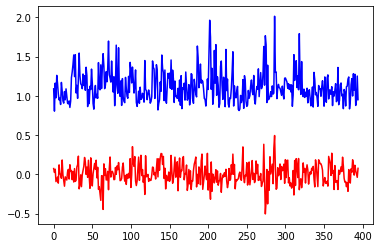

In [6]:
plt.plot(sdXe, 'b')
plt.plot(muXe, 'r')

$\mu$ and $\sigma$ are pretty close to 0 and 1 respectively, and that's because these data are normalized to these wells, but using median and mad. Let's verify.

In [7]:
madXe = scipy.stats.median_absolute_deviation(Xe, 0) 
medXe = np.median(Xe, 0)

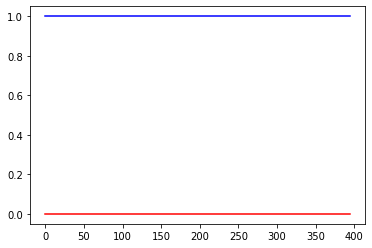

In [8]:
plt.plot(madXe, 'b')
plt.plot(medXe, 'r')

## Inspect perturbations wells

In [9]:
perturbations = profiles.query("Metadata_gene_name != 'EMPTY' & Metadata_cell_line == 'HCC44' & Metadata_Plate == 'SQ00014618'")
print(perturbations.shape)
perturbations.head()

(328, 402)


,Metadata_Plate,Metadata_Well,Metadata_WellCol,Metadata_WellRow,Metadata_cell_line,Metadata_gene_name,Metadata_pert_name,Cells_AreaShape_Compactness,Cells_AreaShape_Extent,Cells_AreaShape_Zernike_0_0,Cells_AreaShape_Zernike_1_1,Cells_AreaShape_Zernike_2_0,Cells_AreaShape_Zernike_2_2,Cells_AreaShape_Zernike_3_3,Cells_AreaShape_Zernike_4_0,Cells_AreaShape_Zernike_4_2,Cells_AreaShape_Zernike_5_1,Cells_AreaShape_Zernike_5_3,Cells_AreaShape_Zernike_6_0,Cells_AreaShape_Zernike_6_2,Cells_AreaShape_Zernike_6_4,Cells_AreaShape_Zernike_7_1,Cells_AreaShape_Zernike_7_3,Cells_AreaShape_Zernike_8_0,Cells_AreaShape_Zernike_8_2,Cells_AreaShape_Zernike_8_4,Cells_AreaShape_Zernike_8_6,Cells_AreaShape_Zernike_9_1,Cells_AreaShape_Zernike_9_3,Cells_AreaShape_Zernike_9_5,Cells_Correlation_Correlation_DNA_ER,Cells_Correlation_Correlation_DNA_Mito,Cells_Correlation_Correlation_ER_RNA,Cells_Correlation_Correlation_Mito_AGP,Cells_Correlation_Correlation_Mito_RNA,Cells_Correlation_K_AGP_DNA,Cells_Correlation_K_AGP_ER,Cells_Correlation_K_Mito_DNA,Cells_Correlation_K_RNA_DNA,Cells_Correlation_Overlap_DNA_AGP,...,Nuclei_Texture_Entropy_RNA_5_0,Nuclei_Texture_Gabor_AGP_10,Nuclei_Texture_Gabor_AGP_20,Nuclei_Texture_Gabor_DNA_10,Nuclei_Texture_Gabor_DNA_20,Nuclei_Texture_Gabor_DNA_5,Nuclei_Texture_Gabor_ER_20,Nuclei_Texture_Gabor_ER_5,Nuclei_Texture_Gabor_Mito_10,Nuclei_Texture_Gabor_Mito_20,Nuclei_Texture_Gabor_Mito_5,Nuclei_Texture_Gabor_RNA_10,Nuclei_Texture_Gabor_RNA_20,Nuclei_Texture_Gabor_RNA_5,Nuclei_Texture_InfoMeas1_AGP_10_0,Nuclei_Texture_InfoMeas1_AGP_20_0,Nuclei_Texture_InfoMeas1_DNA_10_0,Nuclei_Texture_InfoMeas1_DNA_20_0,Nuclei_Texture_InfoMeas1_ER_5_0,Nuclei_Texture_InfoMeas1_Mito_10_0,Nuclei_Texture_InfoMeas1_RNA_20_0,Nuclei_Texture_InfoMeas2_AGP_20_0,Nuclei_Texture_InfoMeas2_DNA_20_0,Nuclei_Texture_InfoMeas2_RNA_20_0,Nuclei_Texture_InverseDifferenceMoment_AGP_10_0,Nuclei_Texture_InverseDifferenceMoment_AGP_5_0,Nuclei_Texture_InverseDifferenceMoment_DNA_10_0,Nuclei_Texture_InverseDifferenceMoment_DNA_20_0,Nuclei_Texture_InverseDifferenceMoment_ER_10_0,Nuclei_Texture_InverseDifferenceMoment_ER_5_0,Nuclei_Texture_InverseDifferenceMoment_Mito_5_0,Nuclei_Texture_InverseDifferenceMoment_RNA_10_0,Nuclei_Texture_InverseDifferenceMoment_RNA_20_0,Nuclei_Texture_SumAverage_AGP_5_0,Nuclei_Texture_SumAverage_ER_5_0,Nuclei_Texture_SumAverage_Mito_20_0,Nuclei_Texture_SumAverage_RNA_5_0,Nuclei_Texture_SumEntropy_ER_5_0,Nuclei_Texture_SumEntropy_Mito_5_0,Nuclei_Texture_SumEntropy_RNA_5_0
1,SQ00014618,A02,2,A,HCC44,MCL1,MCL1-5,0.246423,0.687241,0.062305,0.289809,-0.855985,1.204420,0.461224,0.368044,0.763090,-0.027289,0.362696,-0.936403,-0.807969,-0.021244,1.419378,-0.665782,0.580061,-1.488709,-1.731853,0.683690,0.605942,1.052981,1.678307,1.253029,-0.035480,-0.786230,-0.929440,-0.776418,-1.297337,0.348772,0.423218,-0.763747,3.812241,...,-2.047731,-1.009490,-2.010605,-0.517114,-0.520303,-0.668994,-0.069873,-1.213468,-0.685377,-0.963529,-0.212635,-0.649470,-0.257140,-3.025899,-0.014031,-0.135907,-0.750494,-0.672724,-0.670345,0.187307,-1.265453,0.695675,0.583097,1.270703,-2.071168,-1.361724,-0.469276,-0.882260,-0.227235,-0.057593,-0.070069,1.855687,-0.400335,3.776635,0.947498,-0.541032,0.363568,0.910251,-0.364015,0.165935
2,SQ00014618,A03,3,A,HCC44,AKT1,AKT1-1,0.416772,0.151184,-0.045541,-0.052603,0.189141,0.513865,0.757945,-0.602882,-0.135608,-0.043348,0.468617,-0.836576,-1.902068,0.022814,0.487900,0.116157,-1.650682,-0.233202,-0.227126,0.279106,1.917556,0.161677,-0.598440,0.348555,-1.513462,-3.286210,-2.055937,-3.722152,-1.014923,0.125833,-0.017301,-0.744144,3.069580,...,-1.349269,-0.325981,-0.452637,0.985699,0.524402,0.808752,1.478936,0.991853,0.908583,1.056609,0.017862,0.581737,1.224450,-1.463615,0.305358,0.317550,1.115262,0.731698,1.292433,2.022317,0.248149,-0.177569,-0.797511,-0.172720,-0.974627,-0.759857,0.676599,0.869965,-0.826075,-1.382562,-1.491414,0.377266,-0.540338,1.743963,-0.510880,-2.206918,-1.440147,-0.571847,-2.261104,-1.358338
3,SQ00014618,A04,4,A

In [10]:
Xp = perturbations.filter(regex="^(?!Metadata)", axis=1).to_numpy()
print(Xp.shape)

(328, 395)


In [11]:
sdXp = np.std(Xp, 0) 
muXp = np.mean(Xp, 0)

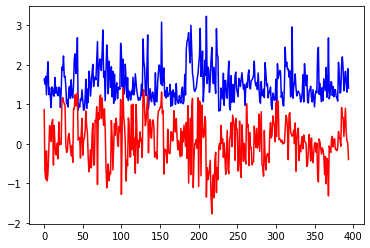

In [12]:
plt.plot(sdXp, 'b')
plt.plot(muXp, 'r')

## Probe current approach 

Let probe into how we've been typically sphering such data. Let's consider the `PCA` [option](https://github.com/cytomining/pycytominer/blob/838ac2eee8bee09b50a1ec8077201c01f7882c69/pycytominer/operations/transform.py#L57) in `pycytominer` but it doesn't matter which one you pick for this analysis.

Here's how we do it (note that $\epsilon$ is very small and that we don't drop the significant PC's)

### Estimate

In [13]:
epsilon=1e-6

mu = np.mean(Xe, 0) 

sd = np.std(Xe, 0) 

X = (Xe - mu) / sd # modification 

# Get the covariance matrix (effectively the correlation matrix because of the scaling above)
C = (1 / X.shape[0]) * np.dot(X.transpose(), X)

s, V = eigh(C)

# Fix sign ambiguity of eigenvectors
V = pd.DataFrame(V * np.sign(np.diag(V)))

# Process the eigenvalues into a diagonal matrix and fix rounding errors
D = np.diag(1.0 / np.sqrt(s.clip(epsilon)))

# Calculate the sphering matrix
W = np.dot(D, V.transpose())

In [14]:
W.shape

(395, 395)

In [53]:
s[d-n]

8.253612754588614e-15

### Apply to reference

In [15]:
Xew = np.dot((Xe - mu) / sd, W.transpose())

In [16]:
Xew.shape

(56, 395)

### Inspect

Note that it is sorted in ascending order, which is atypical (but this is not an issue)

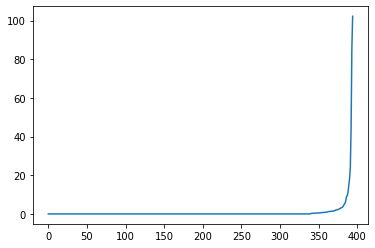

In [17]:
plt.plot(s)

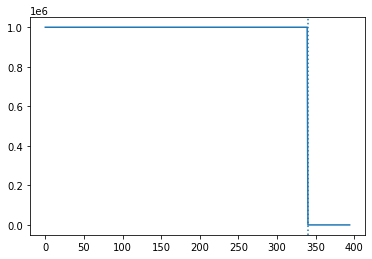

In [18]:
plt.plot(1.0 / s.clip(epsilon))
plt.axvline(d-n+1, 0, ls = ':')

As seen above, we are effectively orthogonally projecting the data into the null space of $X_{negcon}$.

In [19]:
sdXew = np.std(Xew, 0) 
muXew = np.mean(Xew, 0)

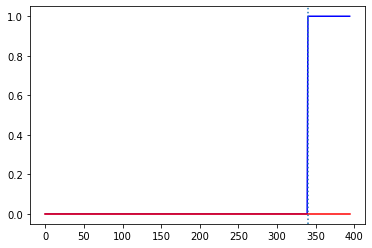

In [20]:
plt.plot(sdXew, 'b')
plt.plot(muXew, 'r')
plt.axvline(d-n+1, 0, ls = ':')

### Apply to perturbations

In [21]:
Xpw = np.dot(Xp - mu, W.transpose())

In [22]:
Xpw.shape

(328, 395)

### Inspect

In [23]:
sdXpw = np.std(Xpw, 0) 
muXpw = np.mean(Xpw, 0)

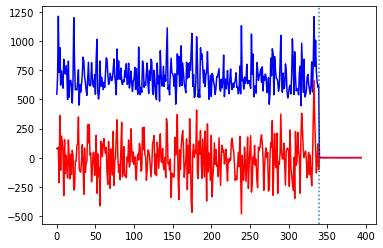

In [24]:
plt.plot(sdXpw, 'b')
plt.plot(muXpw, 'r')
plt.axvline(d-n+1, 0, ls = ':')

This is another demonstration of the fact that we are effectively orthogonally projecting the data into the null space of $X_{negcon}$ if we set $\epsilon$ to a very small value. 

## Improve on current approach

### Estimate

In [25]:
epsilon=1e-6

mu = np.mean(Xe, 0) 

sd = np.std(Xe, 0) 

X = (Xe - mu) / sd 

_, S0, Vt = np.linalg.svd(X, full_matrices=True, compute_uv = True)

V = Vt.transpose()

r = np.linalg.matrix_rank(X) # typically: n - 1 if n < d else d 

# Permute X to find significant PCs
n_permutations = 100

Xr = X.copy()

for i in range(n_permutations):
  np.apply_along_axis(np.random.shuffle, 0, Xr)
  Si = np.linalg.svd(Xr, False, False)[np.newaxis,:]
  if (i == 0):
    Sr = Si
  else:
    Sr = np.append(Sr, Si, axis=0)
    # Sr = Sr.max(0) # if we just want to keep the max

# number of sigificant PC's
fudge = .5 # FIXME likely drop this

k = np.argwhere(S0[0:r] <= Sr.max(0)[0:r] * fudge)[0][0]

# map directly to s.d. of the PCs. This should actually be (n-1) not n.
S = S0 / np.sqrt(n) 

Sf = S + epsilon

if (r < d):

  Sf = np.append(S, np.repeat(0, d - n))

  Sf[r:n] = Sf[r-1]

  Sf[n:d] = Sf[r-1] * np.sqrt(n / d)

Sf0 = Sf.copy() # FIXME: Remove this

Sf = np.sqrt(Sf**2 / np.mean(Sf**2)) # rescale so that sum(Sf**2) = d

assert(np.isclose(sum(Sf**2), d))

Vk = V[:,k:d]

Sk = Sf[k:d]

Sk0 = Sk.copy() # FIXME: Remove this

Sk = np.sqrt(Sk**2 / np.mean(Sk**2)) # rescale so that sum(Sk**2) = d-k

assert(np.isclose(sum(Sk**2), d-k))

# Option 1
W1 = V * 1 / Sf

# Option 2
W2 = Vk * 1 / Sk

# Option 3
W3 = Vk


### Apply function

In [26]:
def spherize(Xinput, method):
  W = {1: W1, 2: W2, 3: W3}
  return ((Xinput - mu) / sd) @ W[method]

### Inspect function

In [27]:
def plot_sd_mu(Xplot, method, data_subset):
  sdXplot = np.std(Xplot, 0)
  muXplot = np.mean(Xplot, 0)
  if method != 1:
    sdXplot = np.append(np.repeat(0, k), sdXplot)
    muXplot = np.append(np.repeat(0, k), muXplot)
  plt.plot(sdXplot, 'b--', label = "sd")
  plt.plot(muXplot, 'r:', label = "mu")
  plt.axvline(r, 0, ls = ':')
  plt.axvline(k, 0, ls = '--')
  plt.legend()
  plt.title(f"Method {method} on {data_subset} data")
  plt.show()

### Inspect spectrum

k = 22; n = 56; r = 55; d = 395; d-k = 373; sqrt(n/d) = 0.38
Sum of variance Sf[1:55] before scaling = 395.00
Sum of variance Sf[56:395] before scaling = 11.66
Sum of variance Sf[56:395] after scaling = 395.00
Sum of variance Sf[22:395] before scaling = 38.59
Sum of variance Sf[22:395] after scaling = 373.00


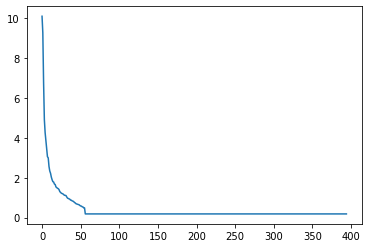

In [28]:
plt.plot(Sf0)
print(f'k = {k}; n = {n}; r = {r}; d = {d}; d-k = {d-k}; sqrt(n/d) = {(n/d)**.5:.2f}')
print(f'Sum of variance Sf[1:{r}] before scaling = {(Sf0[0:r]**2).sum():.2f}')
print(f'Sum of variance Sf[{r+1}:{d}] before scaling = {(Sf0[r:d]**2).sum():.2f}')
print(f'Sum of variance Sf[{r+1}:{d}] after scaling = {(Sf**2).sum():.2f}')
print(f'Sum of variance Sf[{k}:{d}] before scaling = {(Sk0**2).sum():.2f}')
print(f'Sum of variance Sf[{k}:{d}] after scaling = {(Sk**2).sum():.2f}')

Sum of scaled singular values = 395.00
Sum of rescaled singular values = 56.00
Smallest rescaled singular value = 0.18
Smallest rescaled singular value * (d-n) = 61.33


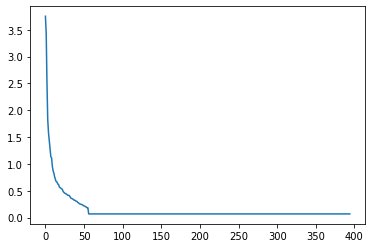

In [29]:
Sx = S0 / np.sqrt(n)
print(f'Sum of scaled singular values = {(Sx**2).sum():.2f}')

Sx = np.sqrt(Sf**2 / np.mean(Sx**2)) # rescale so that sum(Sf**2) = d
print(f'Sum of rescaled singular values = {(Sx**2).sum():.2f}')
print(f'Smallest rescaled singular value = {Sx[r]:.2f}')
print(f'Smallest rescaled singular value * (d-n) = {Sx[r] * (d-n):.2f}')

plt.plot(Sx)

Sum of rescaled singular values of random matrix = 394.97


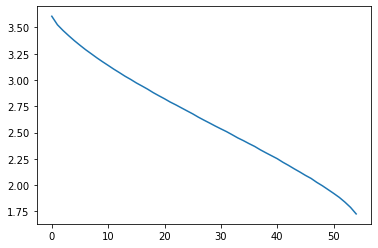

In [30]:
Srmean = Sr.mean(0) / np.sqrt(n)

print(f'Sum of rescaled singular values of random matrix = {(Srmean**2).sum():.2f}')

plt.plot(Srmean[0:r])

2.6330751774251584

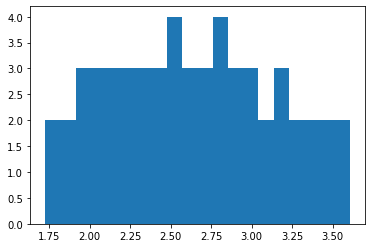

In [31]:
plt.hist(Srmean[0:r], 20)
Srmean[0:r].mean()

In [32]:
print(sum(S0**2) / n)
print(sum(S**2))
print(d)
print(sum(Sf**2))
print(d)
print(sum(Sk**2))
print(d-k)

395.0000000000001
395.00000000000006
395
394.99999999999835
395
372.9999999999936
373


(395, 373)
(373,)
(395, 373)


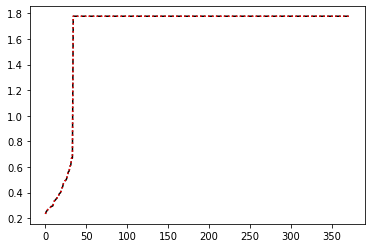

In [33]:
print(Vk.shape)
print(Sk.shape)
print(W2.shape)
plt.plot(np.linalg.norm(W2, axis=0), "k--")
plt.plot(np.sqrt(np.diag(np.matmul(W2.transpose(), W2))), "r:")

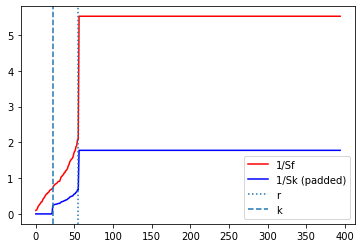

In [34]:
plt.plot(1/Sf, "r", label = "1/Sf")
plt.plot(np.append(np.repeat(0, k), 1/Sk), "b", label = "1/Sk (padded)")
plt.axvline(r, 0, ls = ':', label = "r")
plt.axvline(k, 0, ls = '--', label = "k")
plt.legend()
plt.show()

In [35]:
r = np.linalg.matrix_rank(X)
print(r)
print(n - 1)

55
55


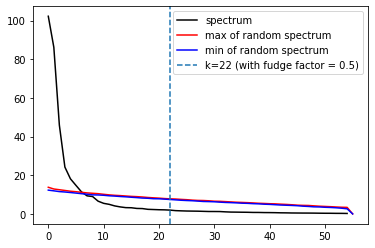

In [36]:
q = 1./n
plt.plot(q * S0[0:r]**2, color = "black", label = "spectrum")
plt.plot(q * Sr[0:r].max(0)**2, color = "red", label = "max of random spectrum")
plt.plot(q * Sr[0:r].min(0)**2, color = "blue", label = "min of random spectrum")
plt.axvline(k, 0, ls = '--', label = f"k={k} (with fudge factor = {fudge})")
plt.legend()
plt.show()

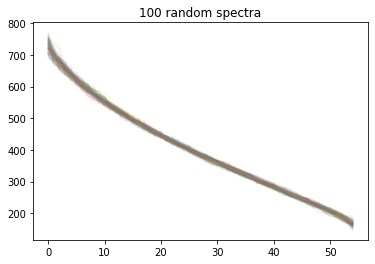

In [37]:
plt.plot((Sr**2)[:,0:r].transpose(), alpha = 0.1)
plt.title(f"{n_permutations} random spectra")
plt.show()

### Inspect correlation structure in top PCs

In [38]:
import seaborn as sns

In [39]:
%config InlineBackend.figure_format = 'retina'

In [40]:
def plot_feature_corr(pc, pct):
  pc1_top = colnames[np.argwhere(abs(V[:,pc]) > np.percentile(abs(V[:,pc]), pct)).squeeze()]
  sns.clustermap(
      data[pc1_top].corr(), 
      metric="correlation", 
      vmin=-1, 
      vmax=1,
      cmap=sns.diverging_palette(20, 220, n=200)
      ).fig.suptitle(f"pc = {pc}. pct = {pct}")
  

In [41]:
data = empty.filter(regex="^(?!Metadata)", axis=1)
#data = (data * np.sign(data.mean()))

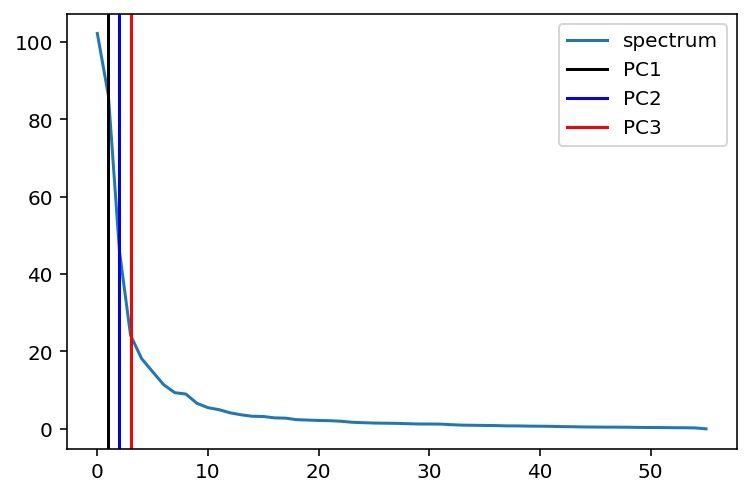

In [54]:
plt.plot((S0**2)/n, label = "spectrum")
plt.axvline(1, 0, color = 'k', label = "PC1")
plt.axvline(2, 0, color = 'b', label = "PC2")
plt.axvline(3, 0, color = 'r', label = "PC3")
plt.legend()
plt.show()

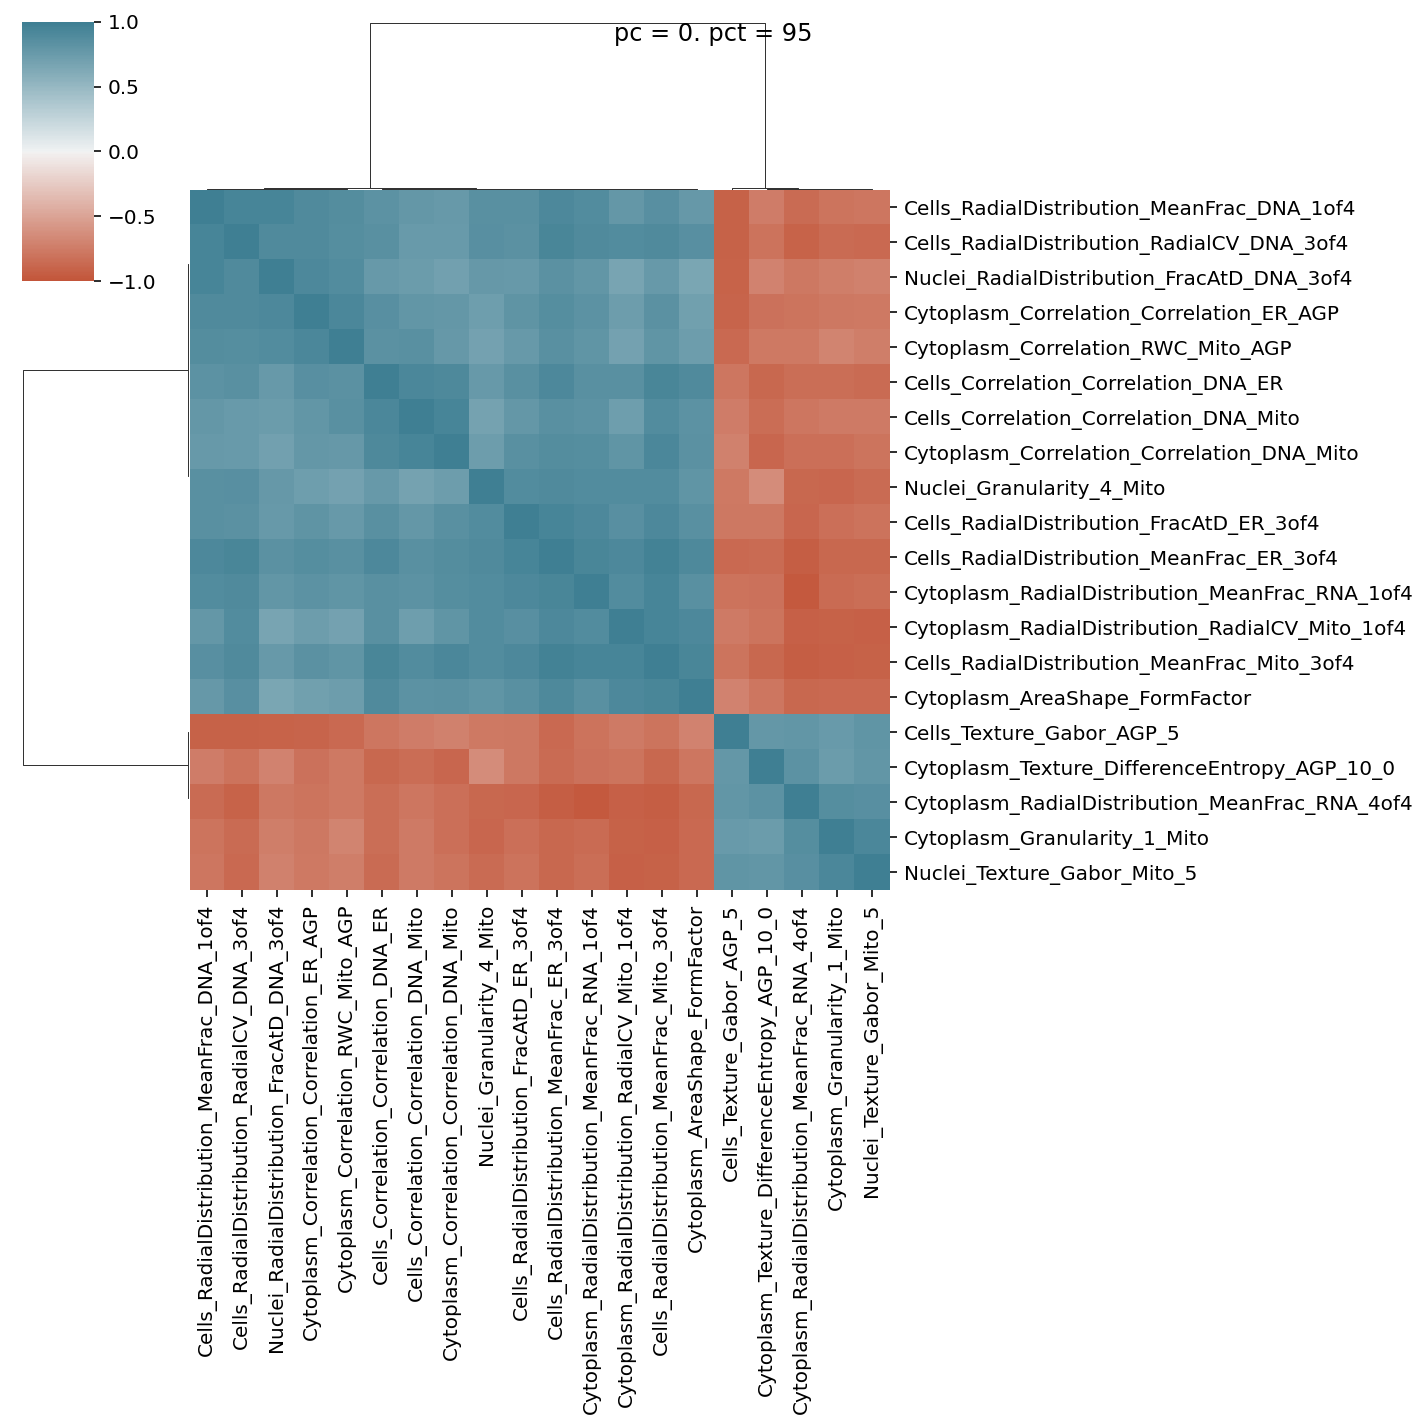

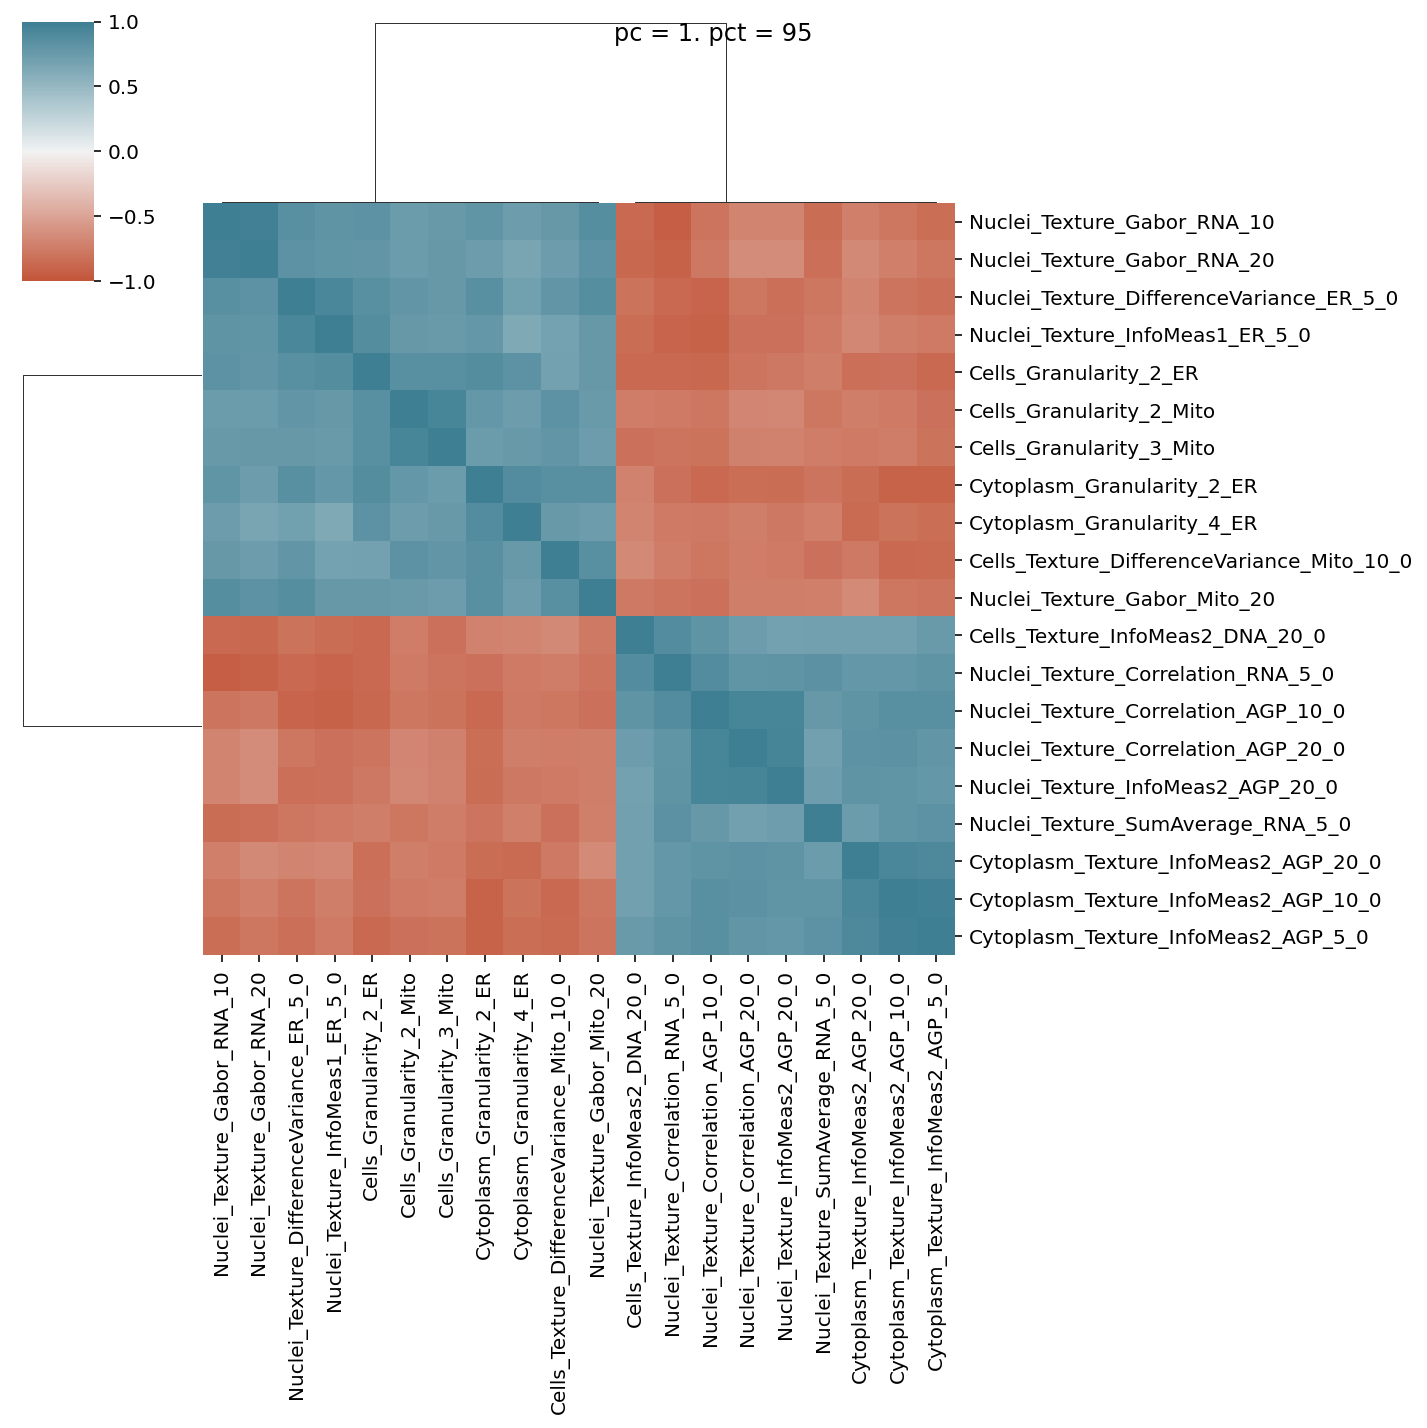

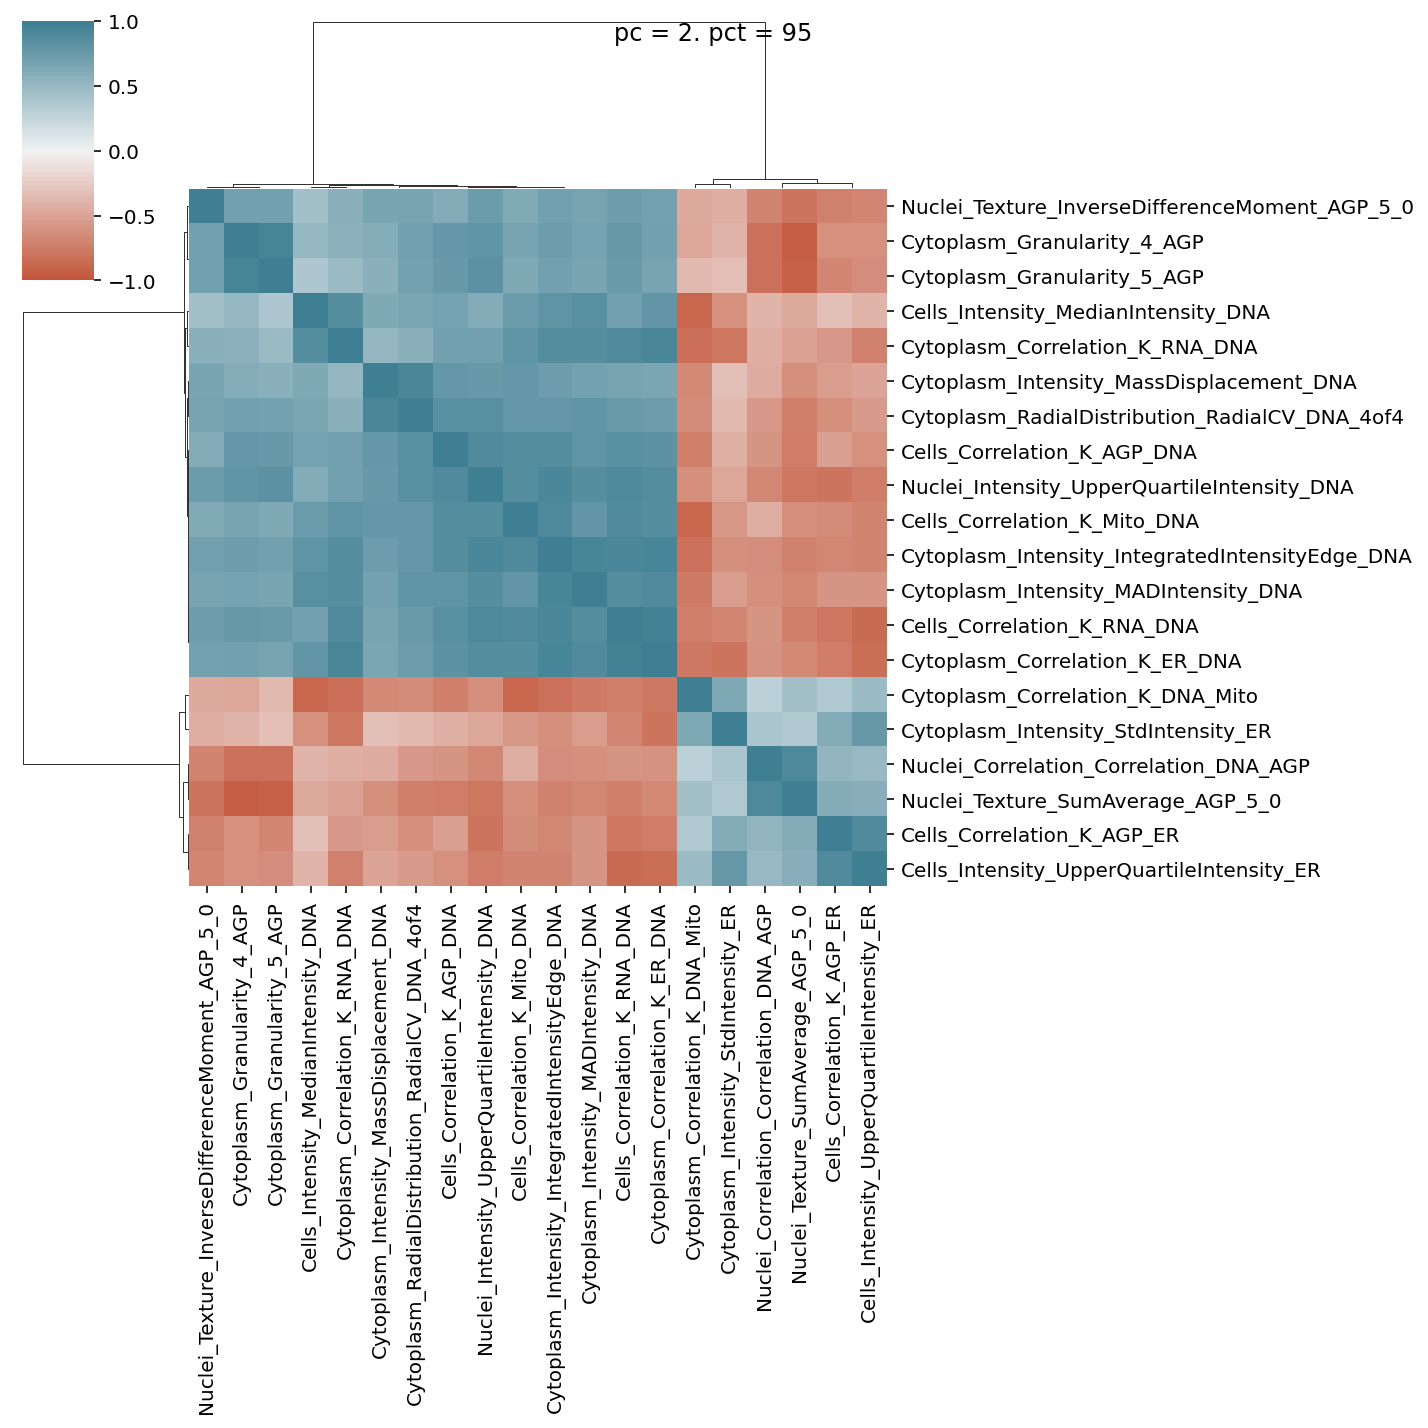

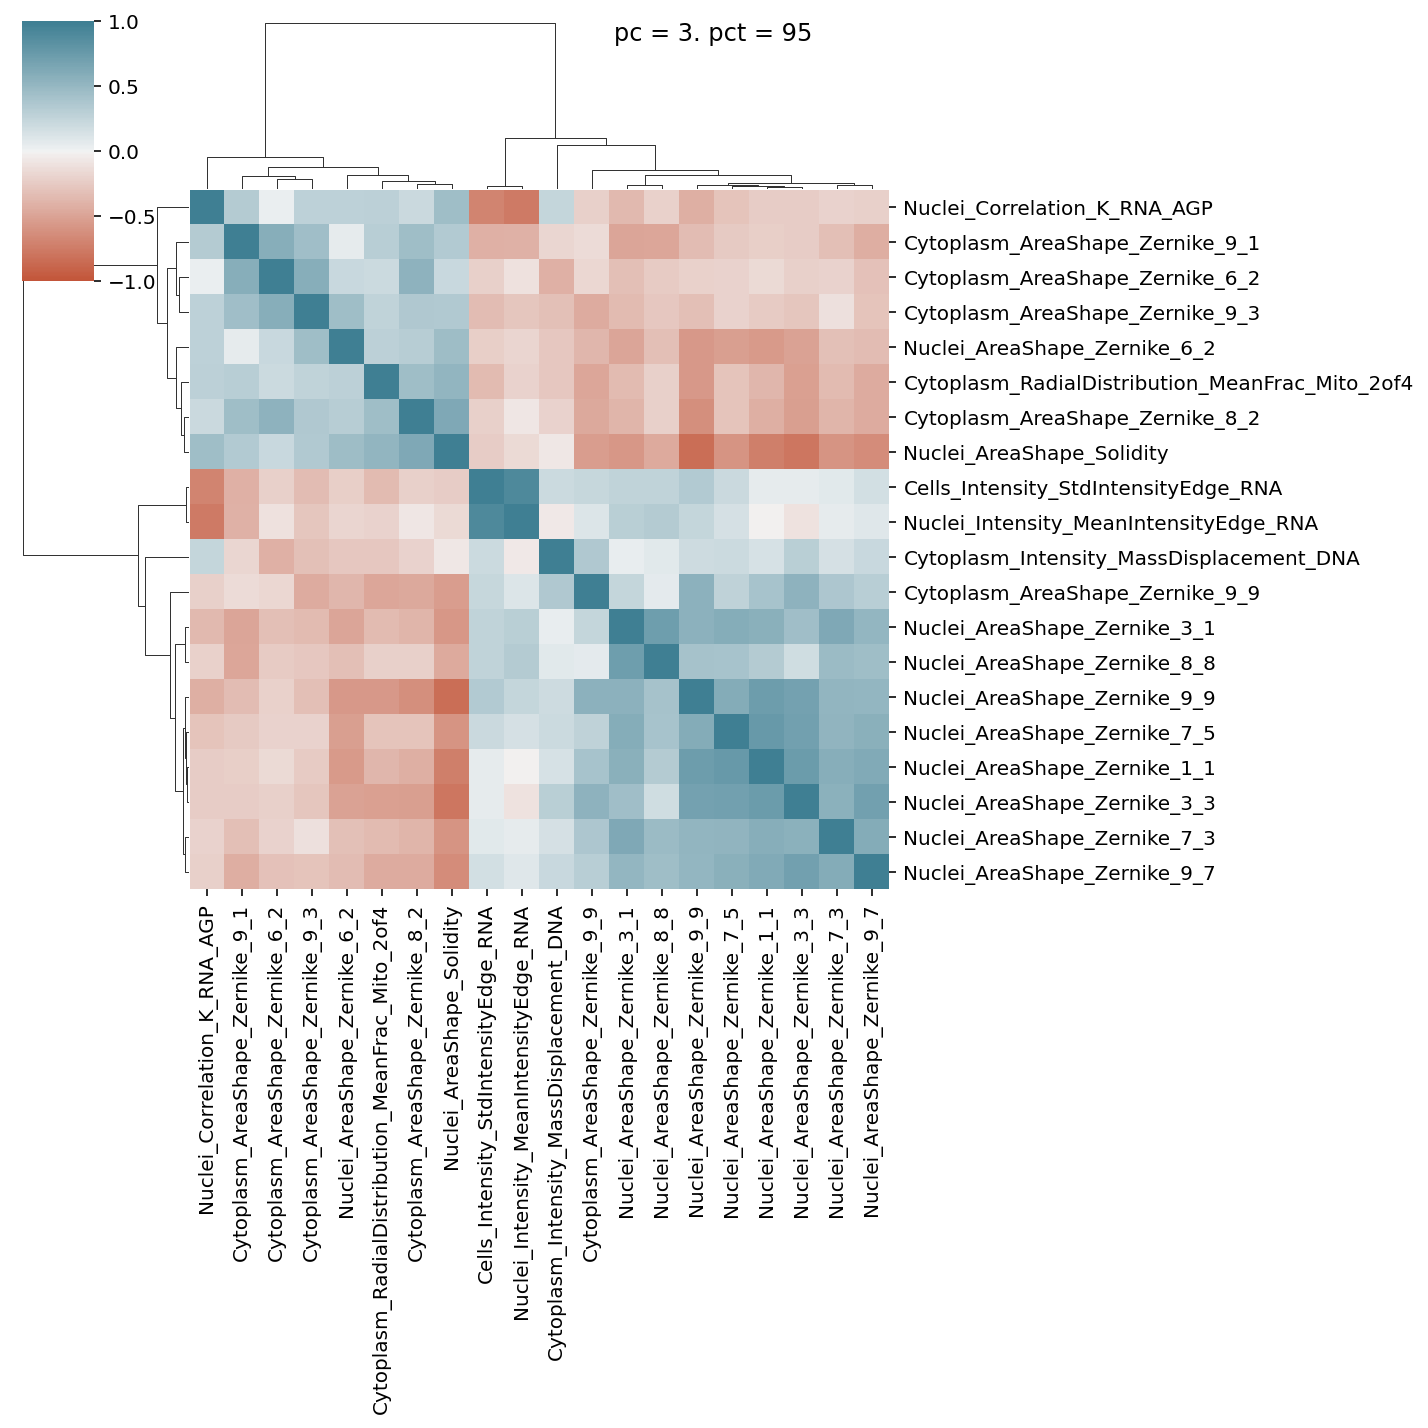

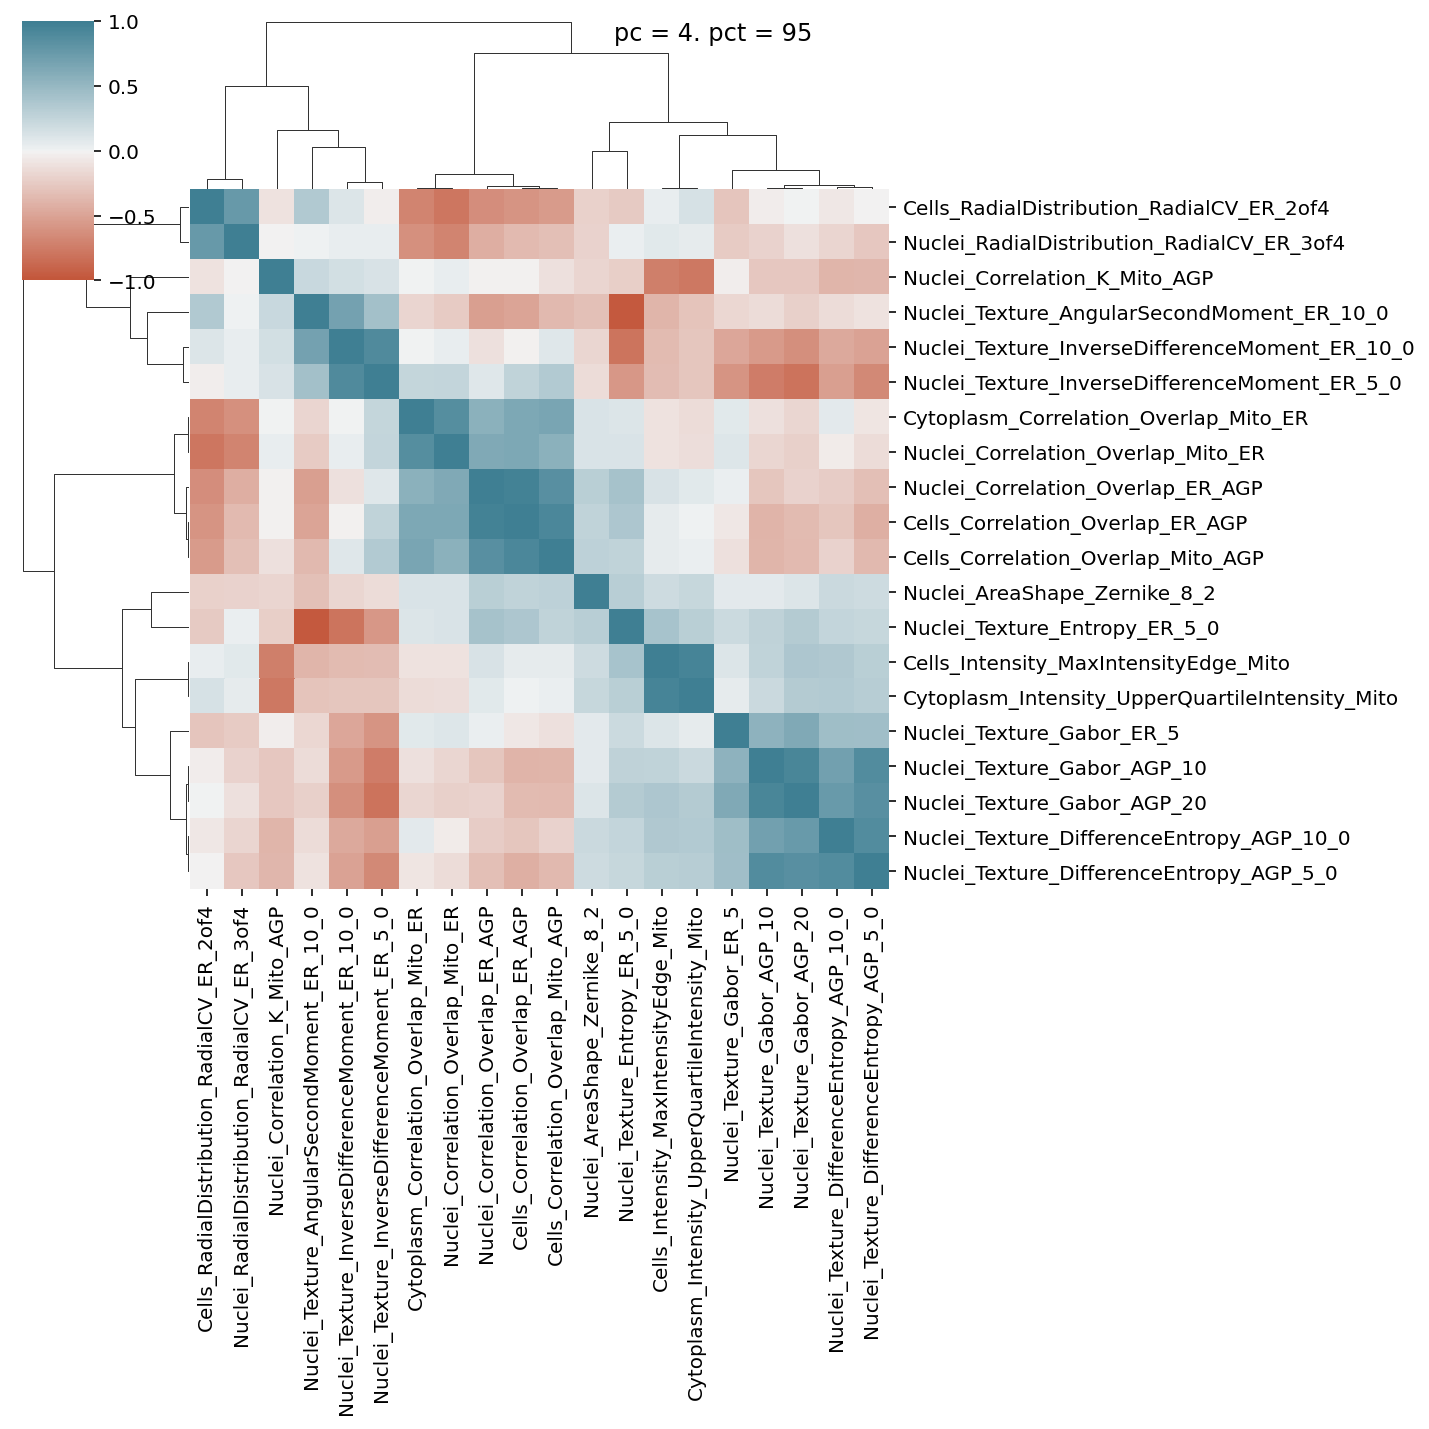

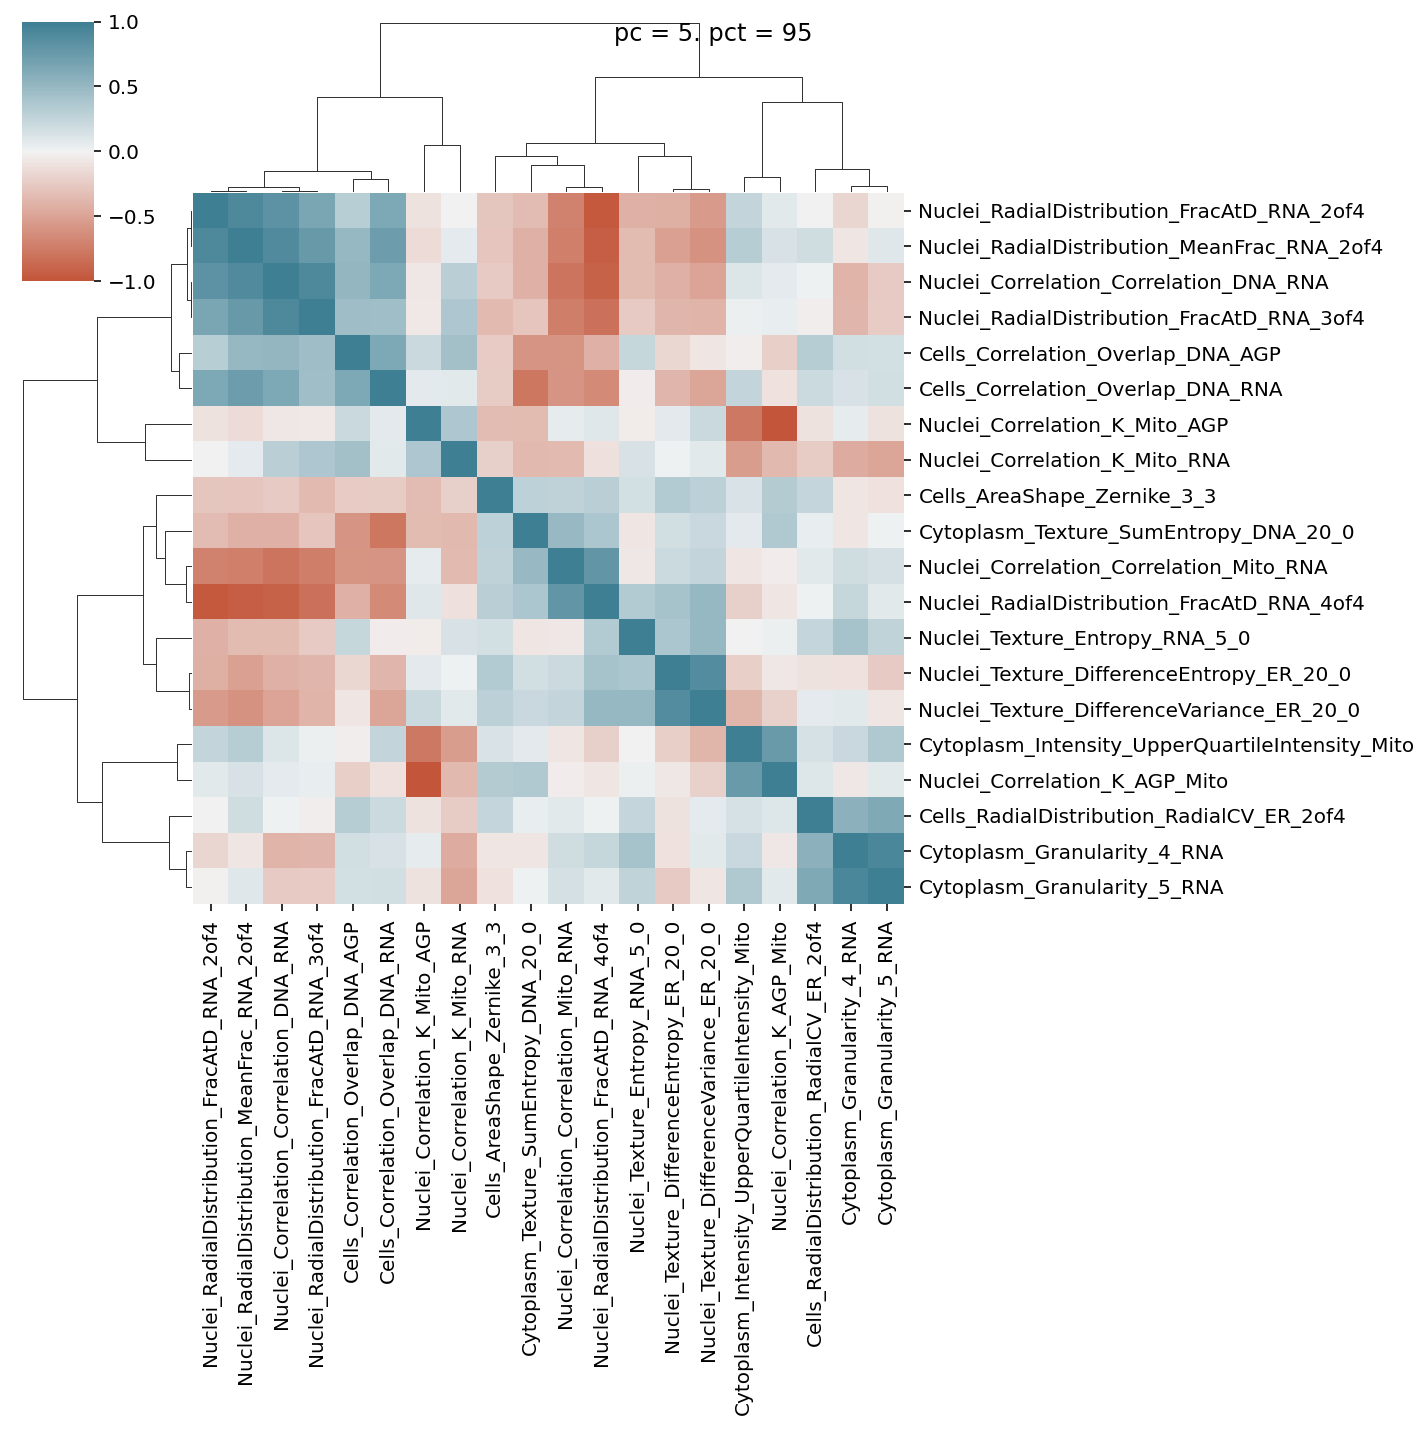

In [43]:
plot_feature_corr(pc = 0, pct = 95)
plot_feature_corr(pc = 1, pct = 95)
plot_feature_corr(pc = 2, pct = 95)
plot_feature_corr(pc = 3, pct = 95)
plot_feature_corr(pc = 4, pct = 95)
plot_feature_corr(pc = 5, pct = 95)


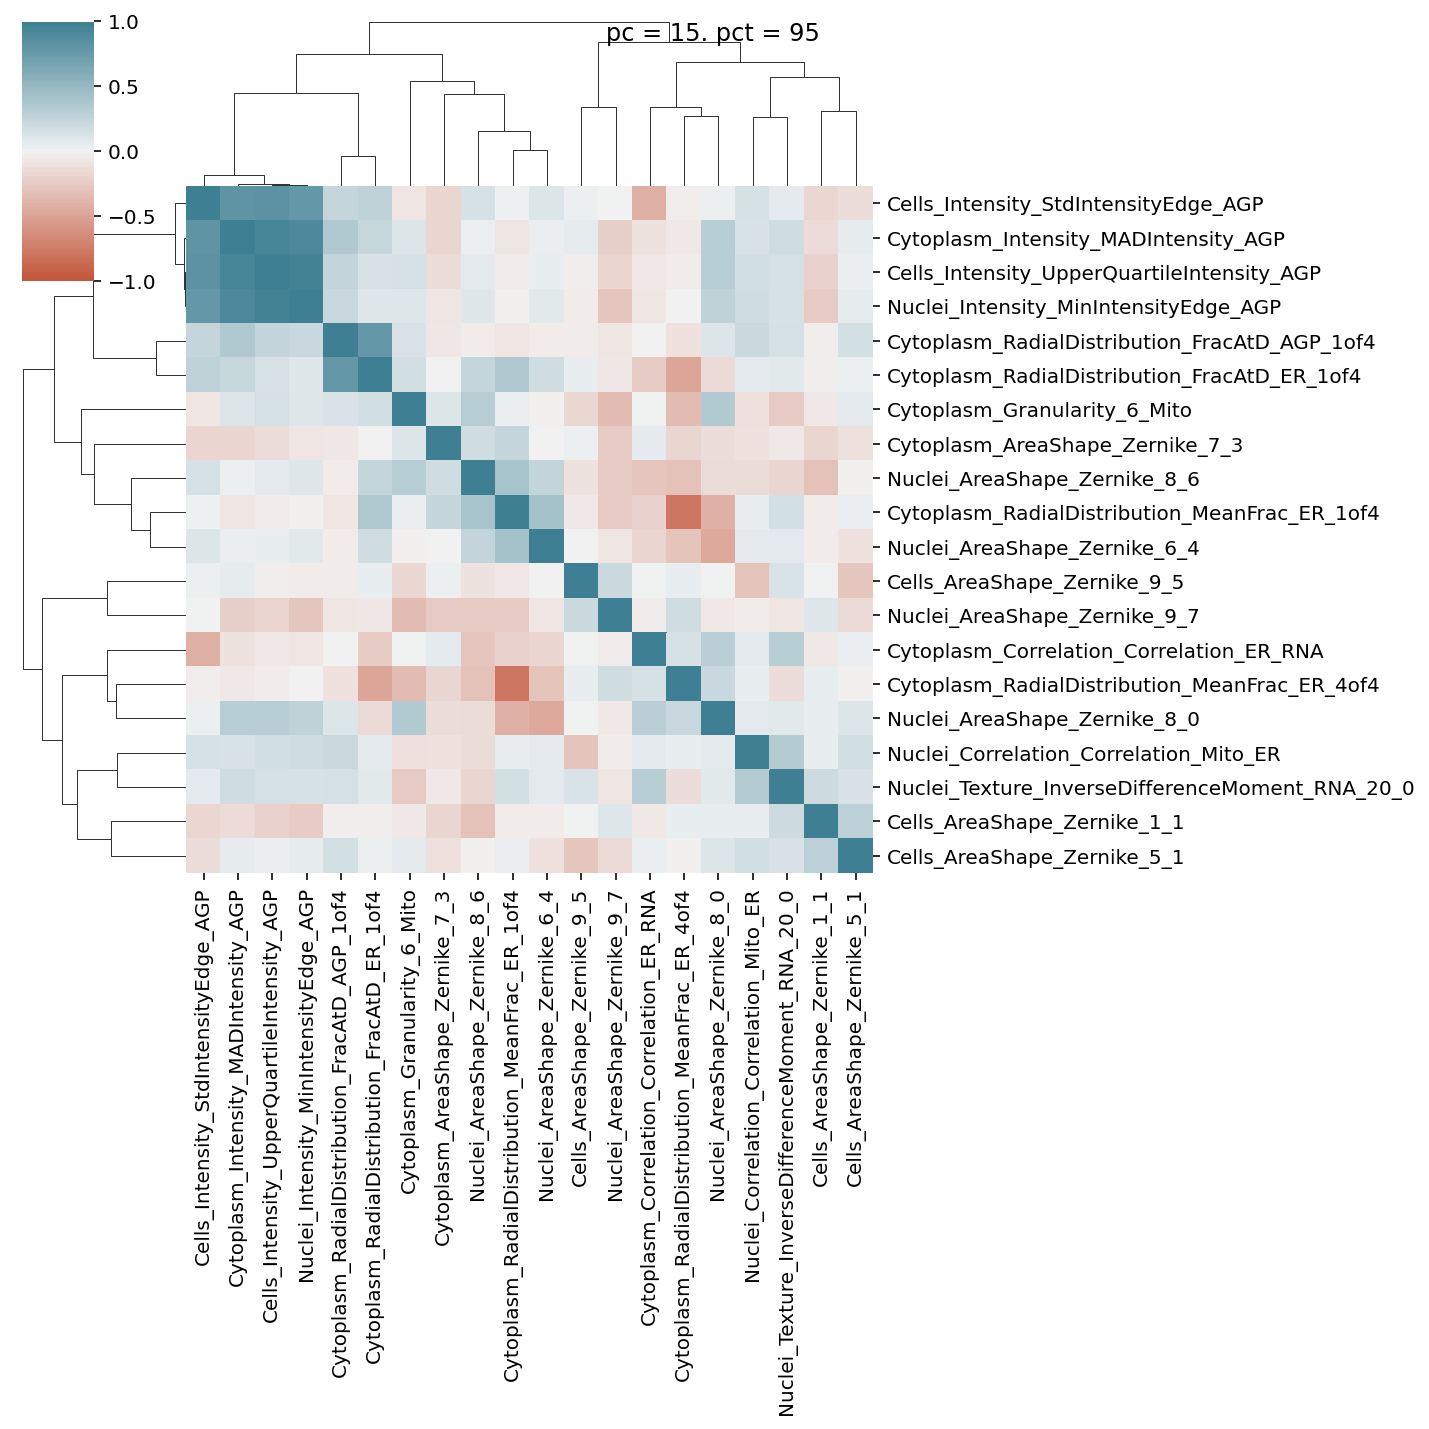

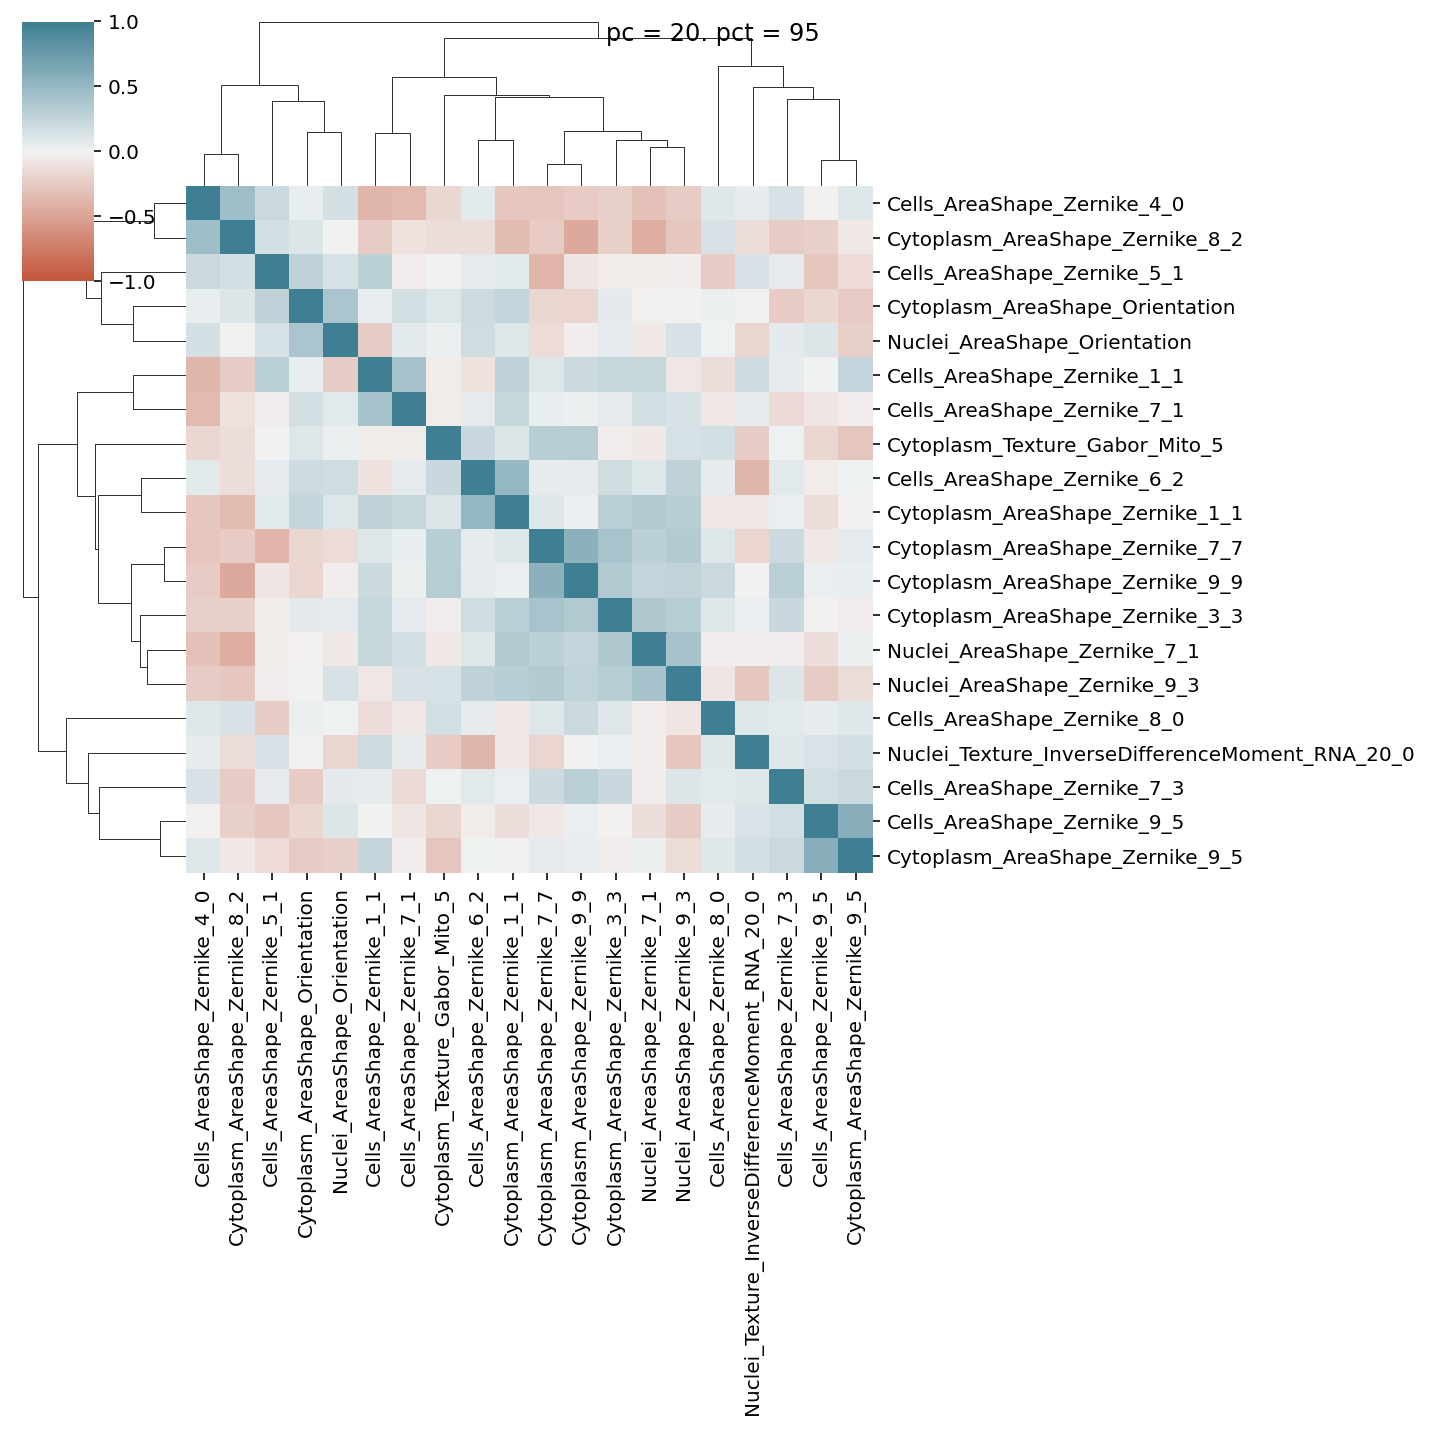

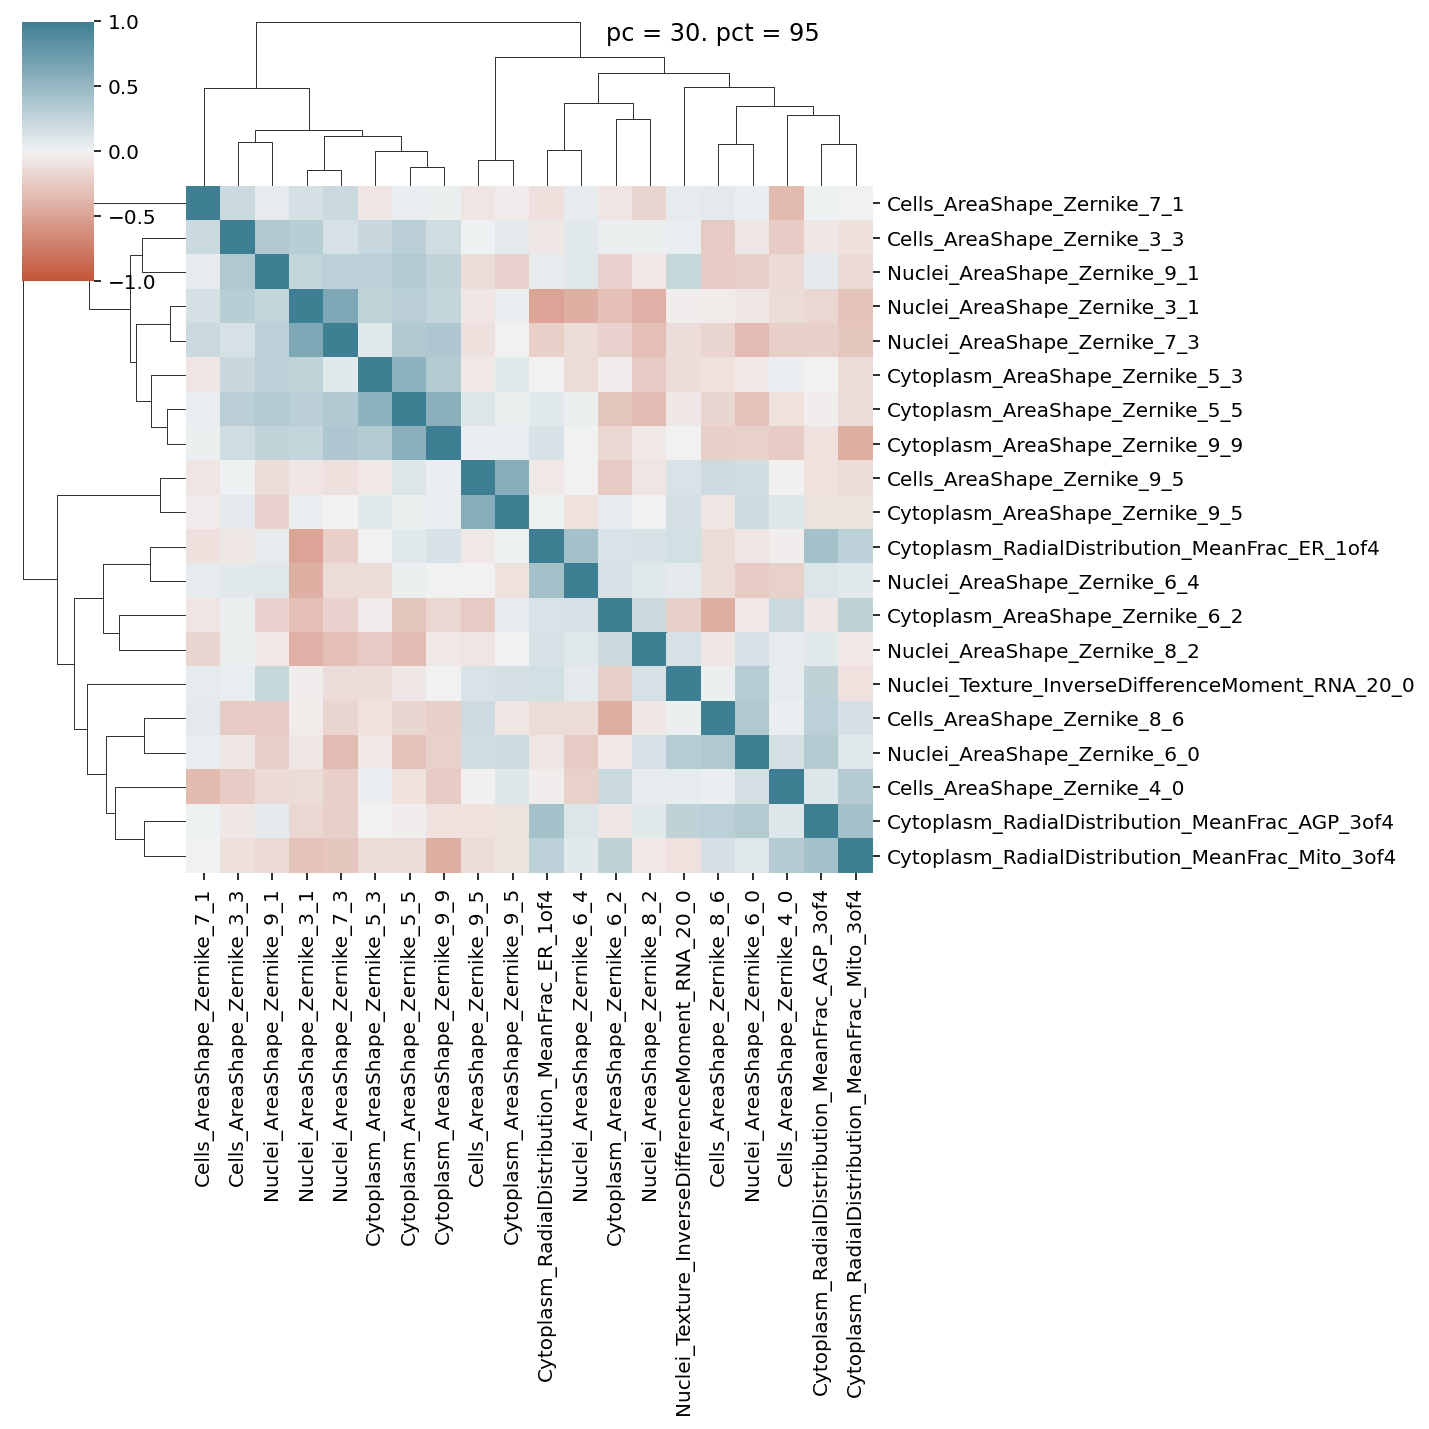

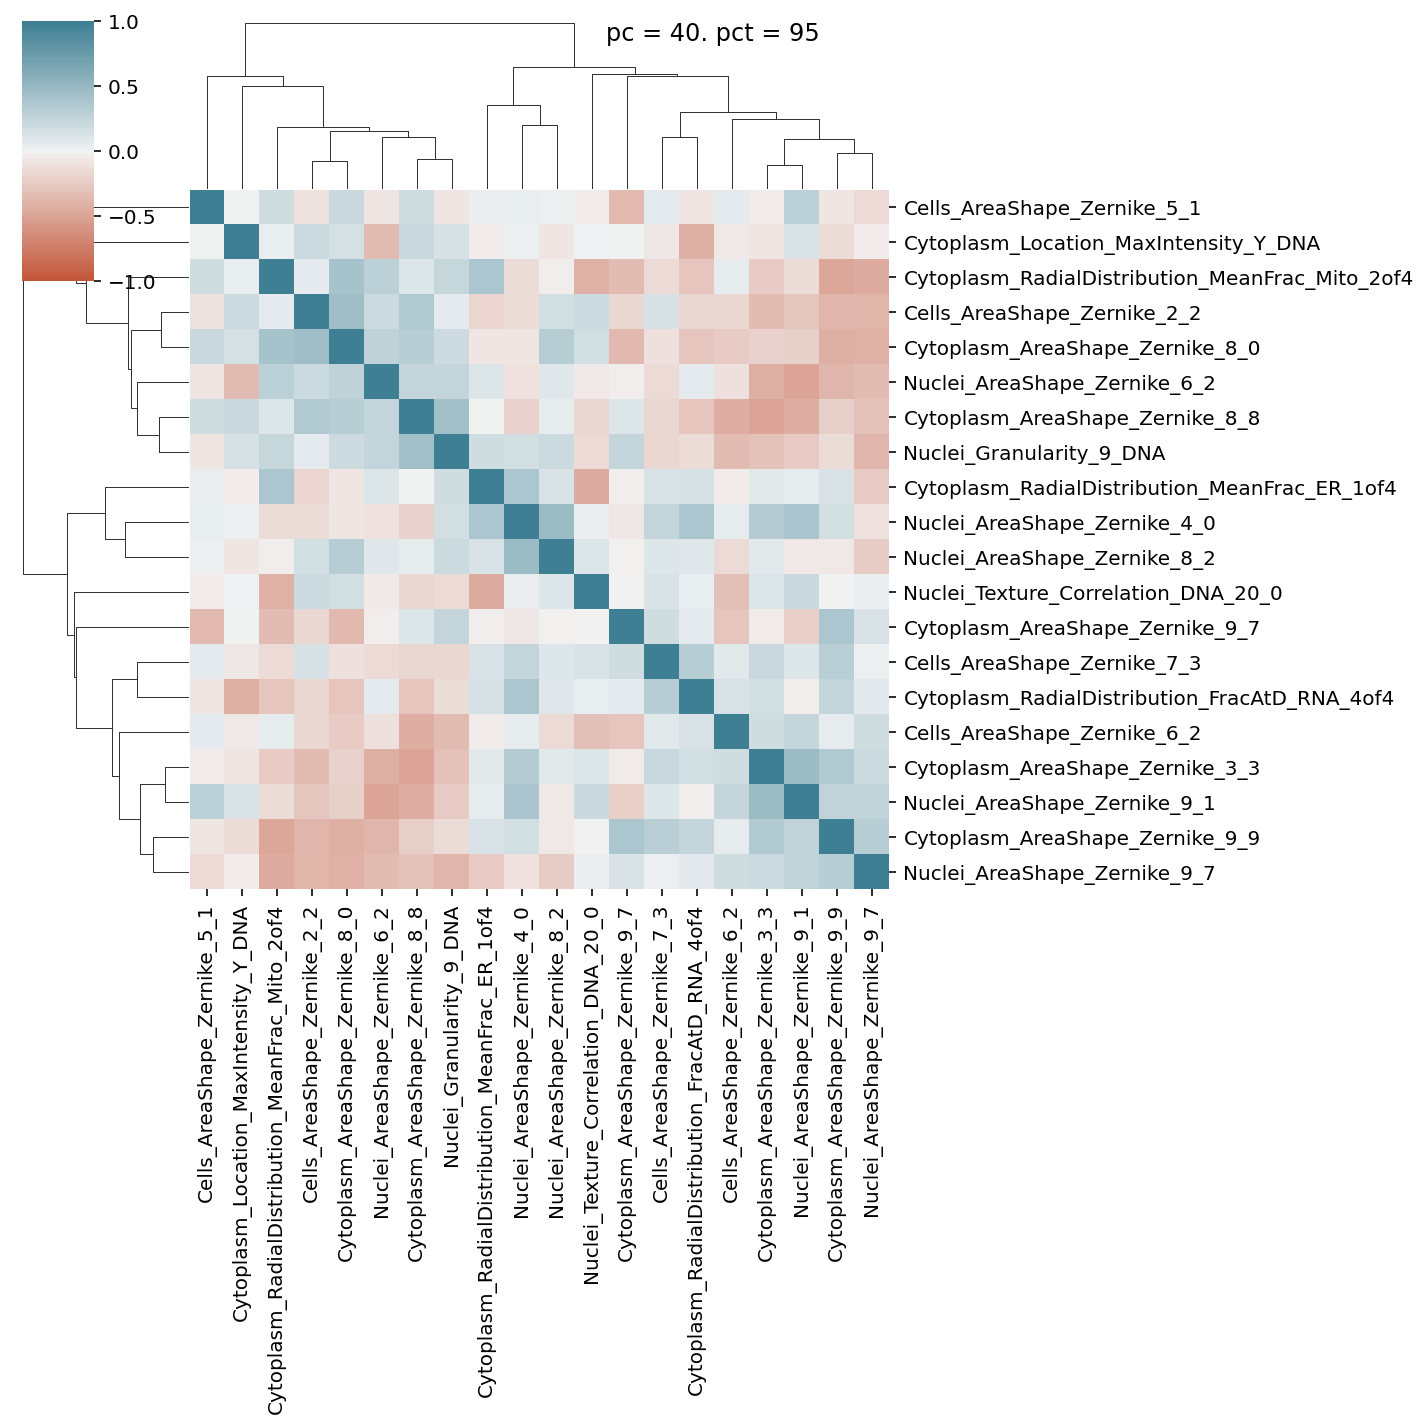

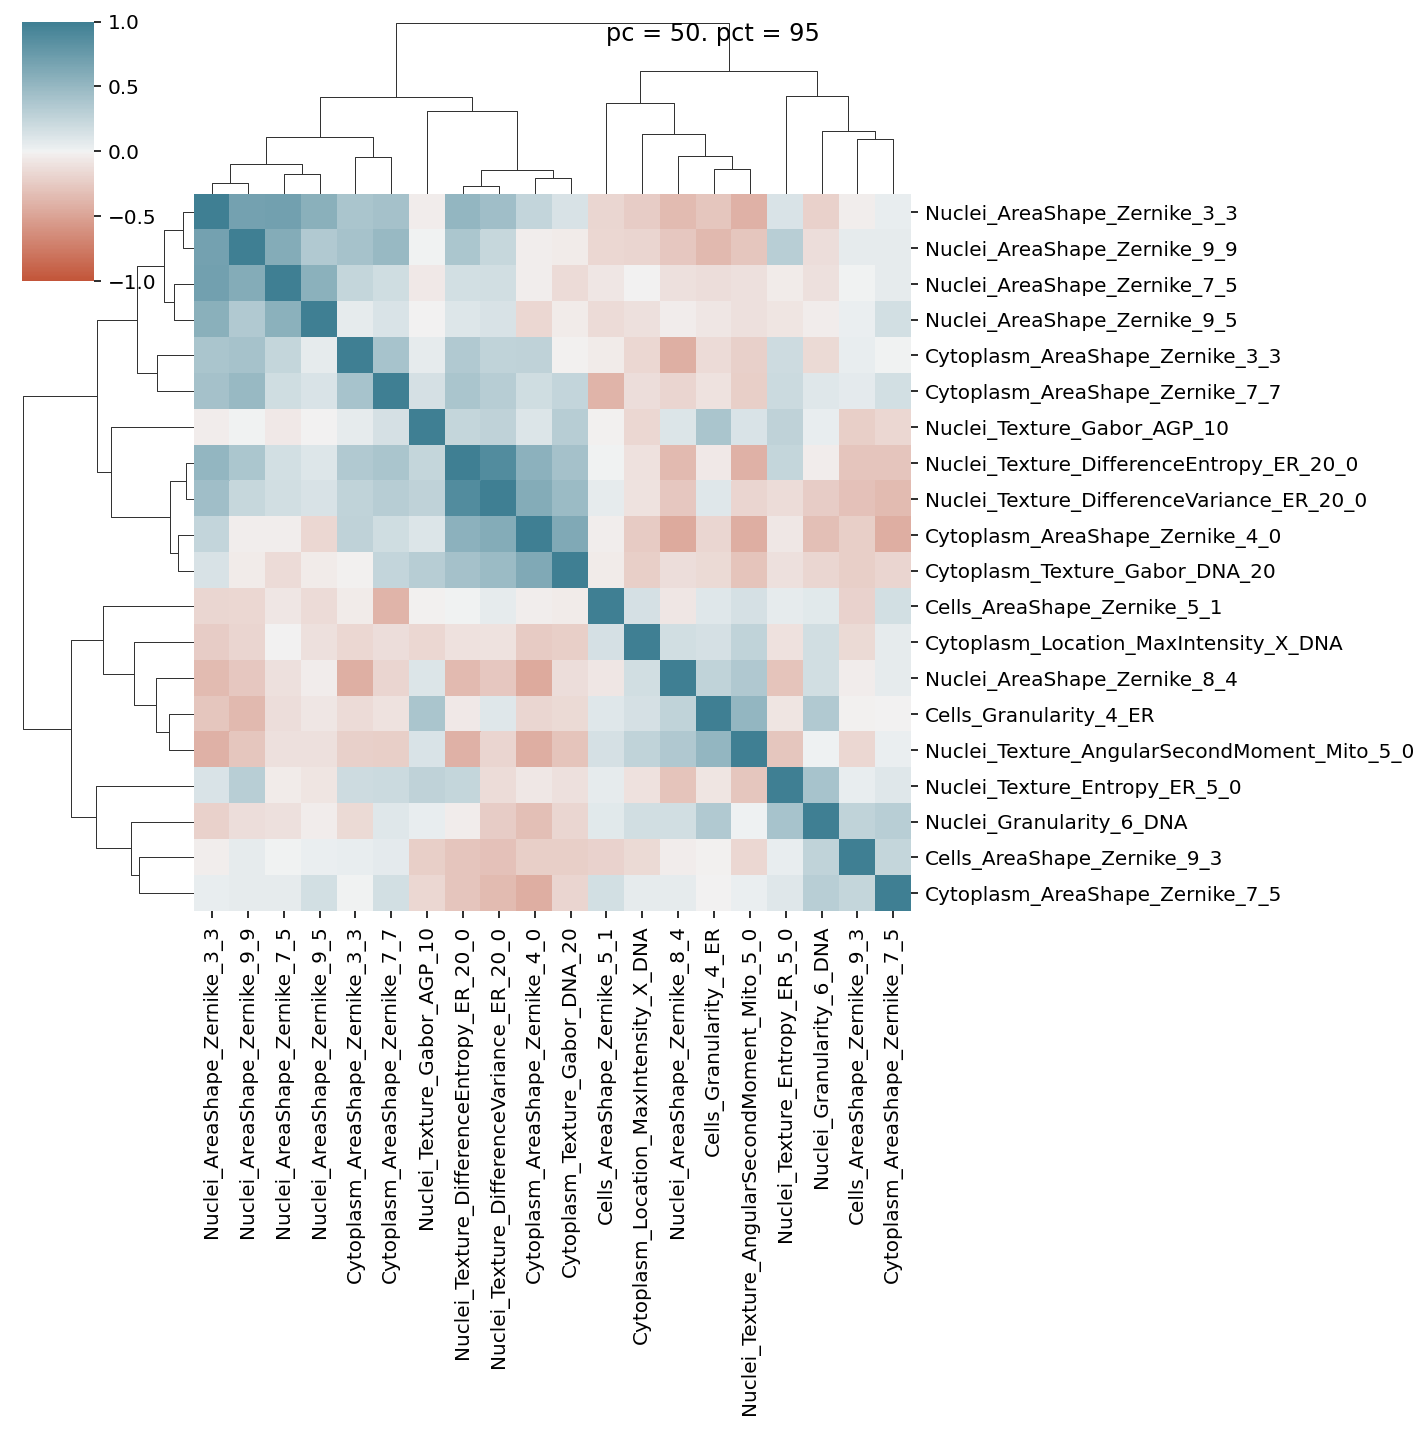

In [44]:
plot_feature_corr(pc = 15, pct = 95)
plot_feature_corr(pc = 20, pct = 95)
plot_feature_corr(pc = 30, pct = 95)
plot_feature_corr(pc = 40, pct = 95)
plot_feature_corr(pc = 50, pct = 95)

### Apply to reference and inspect

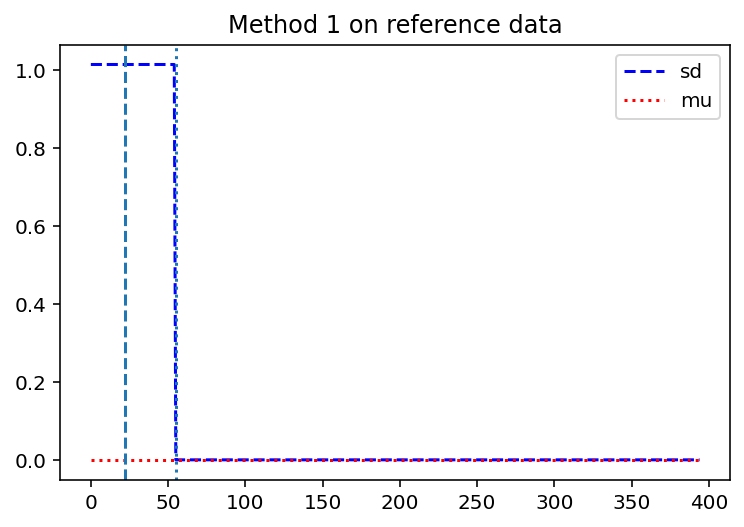

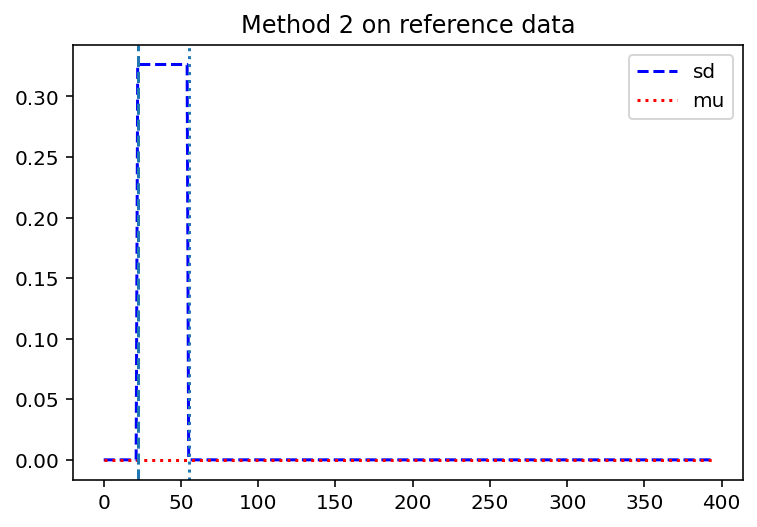

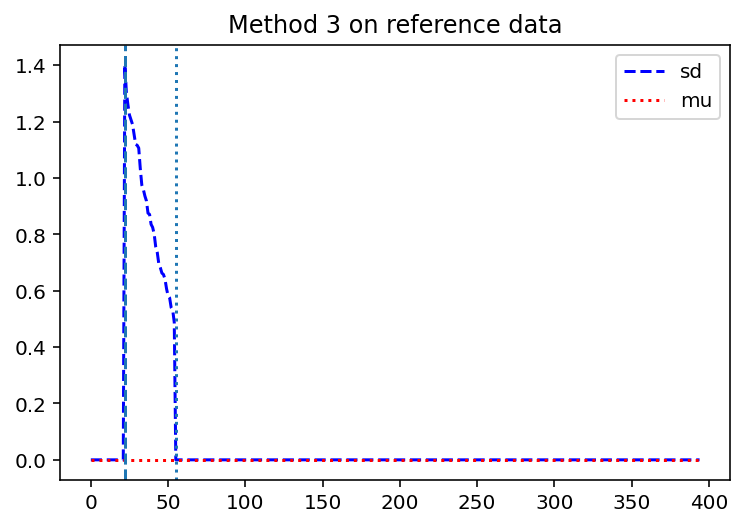

In [45]:
plot_sd_mu(spherize(Xe, method = 1), method = 1, data_subset = "reference")
plot_sd_mu(spherize(Xe, method = 2), method = 2, data_subset = "reference")
plot_sd_mu(spherize(Xe, method = 3), method = 3, data_subset = "reference")

### Apply to perturbations and inspect

### Inspect

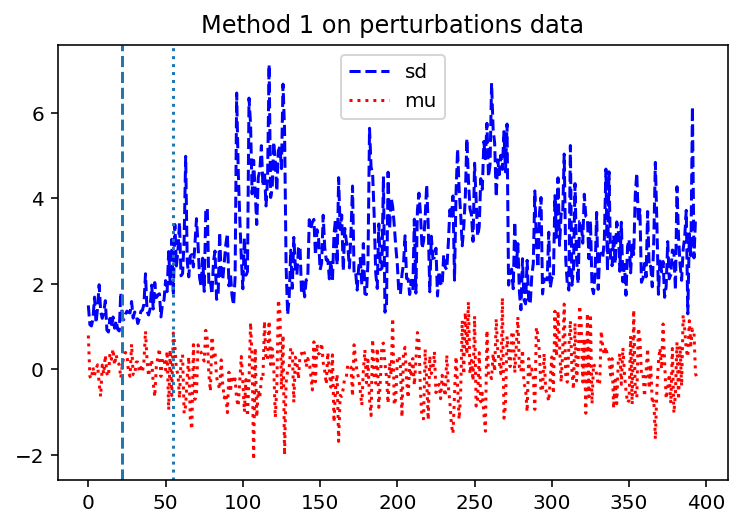

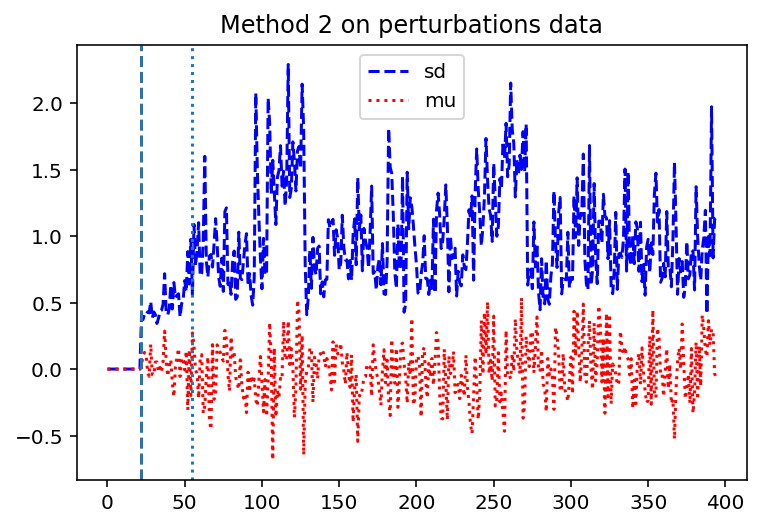

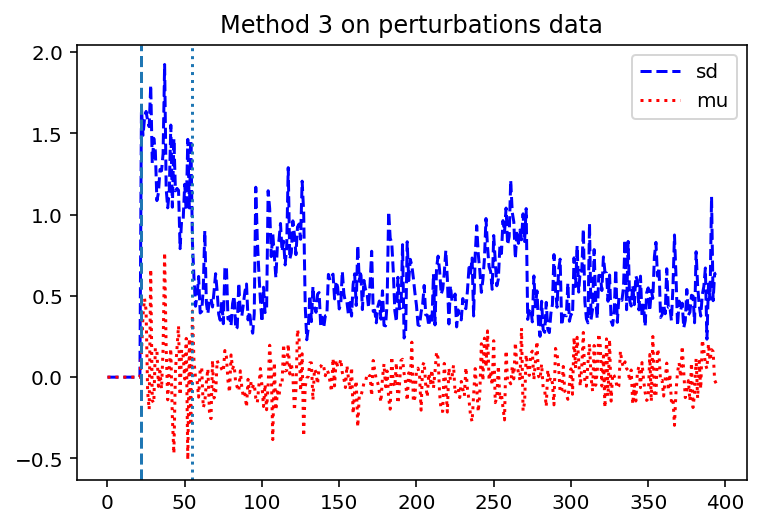

In [46]:
plot_sd_mu(spherize(Xp, method = 1), method = 1, data_subset = "perturbations")
plot_sd_mu(spherize(Xp, method = 2), method = 2, data_subset = "perturbations")
plot_sd_mu(spherize(Xp, method = 3), method = 3, data_subset = "perturbations")